# Pink Noise is 1/f noise

This simulator will generate pink noise and attempt to mitigate it using wavelets and gaussian processes

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"]      = 300
rcParams["figure.dpi"]       = 300
rcParams['errorbar.capsize'] = 0.0

from matplotlib.colors import LogNorm
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math
import os
import threading, subprocess

from astroML.plotting import hist

from sys import platform

from pylab import *;ion()

from time import time

from pymultinest.solve import Solver,solve

if not os.path.exists("chains"): os.mkdir("chains")

from celerite import plot_setup
plot_setup.setup()

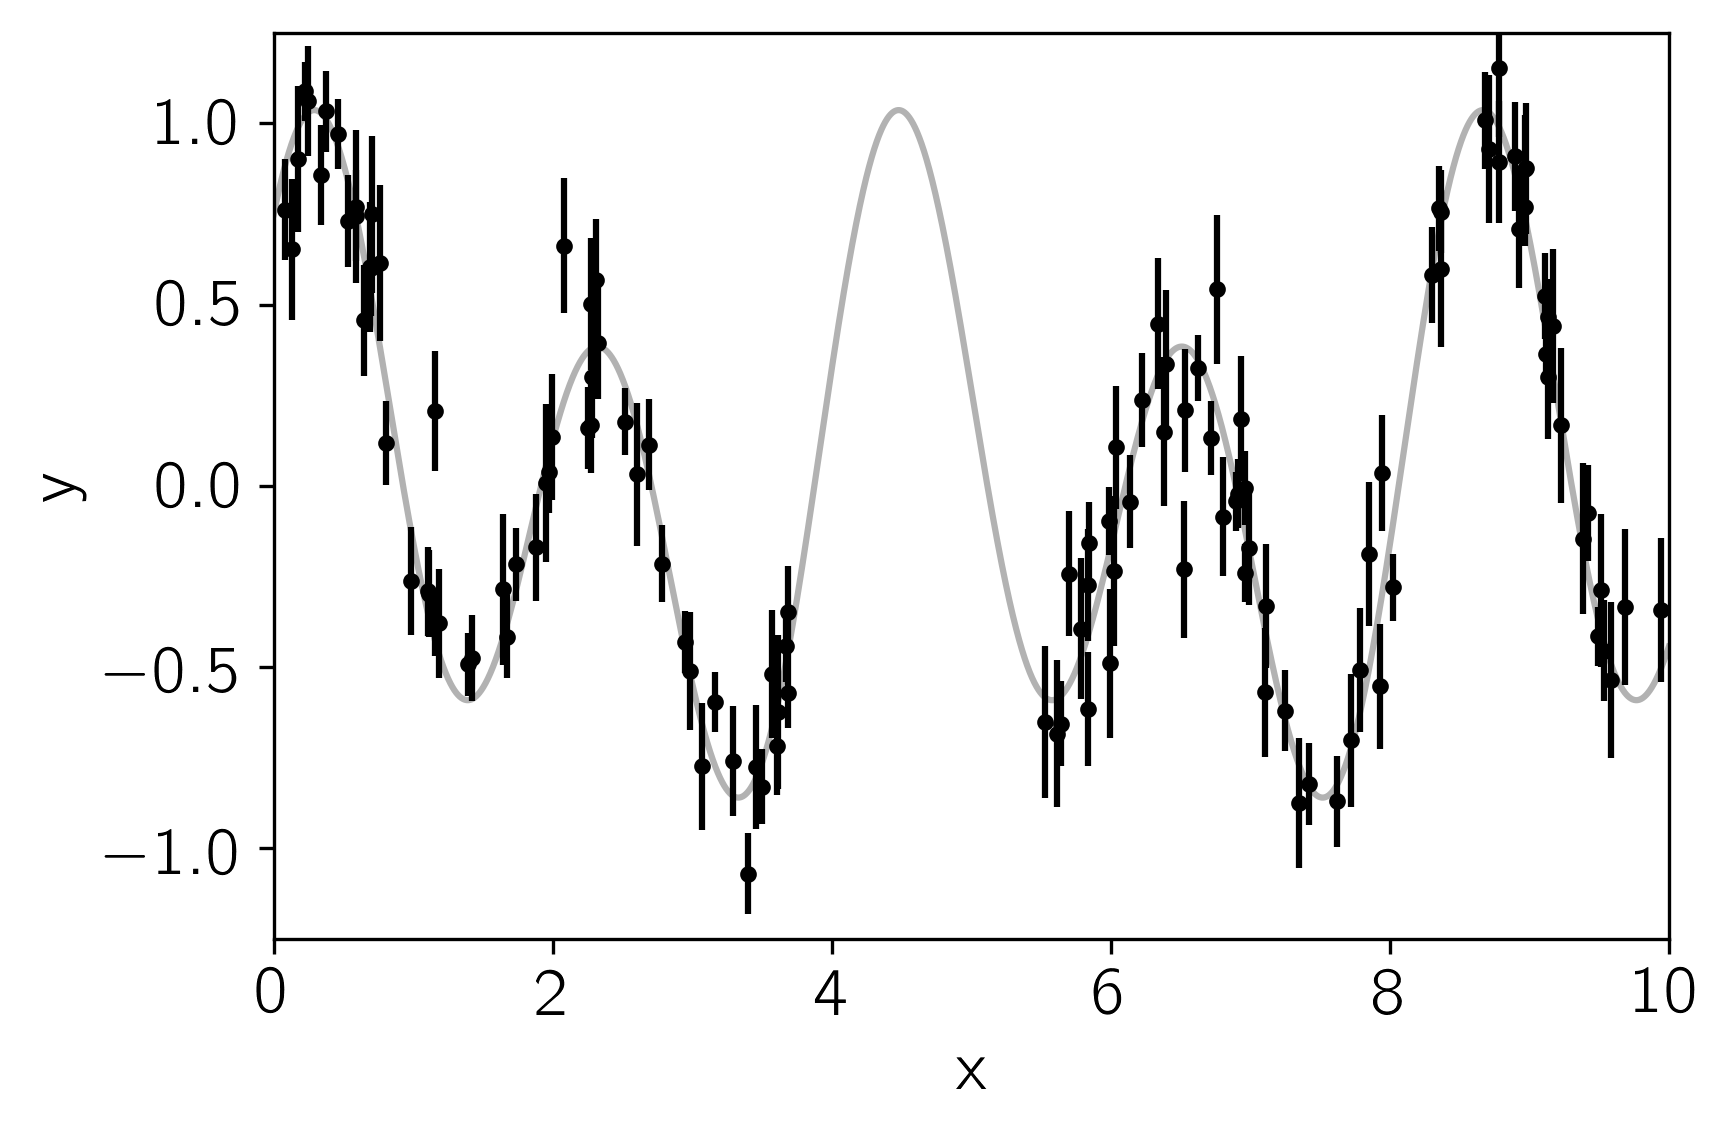

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def quasi_periodic_oscillation(abscissa, coeffs, phaseOffset = 5):
    assert(len(coeffs) == 4)
    t = abscissa
    c = coeffs
    po= phaseOffset
    return c[0] * (t-po) + c[1]*np.sin(c[2]*t + c[3]*(t-po)**2) + c[4]*np.cos(c[2]*t + c[3]*(t-po)**2)

def fourier_function(abscissa, coeffs):
    assert(len(coeffs) == 3)
    t = abscissa
    c = coeffs
    return c[0]*np.sin(c[1]*t) + c[2]*np.cos(c[1]*t) 

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
# y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

params1 = [.5, 3,.5]
params2 = [.25, 3/2,.25]

true_t = np.linspace(0, 10, 5000)
# true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

true_y = fourier_function(true_t, params1)+fourier_function(true_t, params2)
y = fourier_function(t, params1)+fourier_function(t, params2) + yerr * np.random.randn(len(t))

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-1.25, 1.25);

# Gaussian Processes

**Gaussian Processes with Celerite "first" example**

https://github.com/dfm/celerite/blob/master/docs/_static/notebooks/first.ipynb

**Pink Noise Generator**

https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py

**Gaussian Processes for 1D Gaussian Fitting**

**SHOTerm PSD**

$$S(\omega) = \sqrt{\frac{2}{\pi}} \frac{S_0\,\omega_0^4}
    {(\omega^2-{\omega_0}^2)^2 + {\omega_0}^2\,\omega^2/Q^2}$$
    
**Real Term PSD**
$$k(\tau) = a_j\,e^{-c_j\,\tau}$$

In [3]:
def ms(x):
    """Mean value of signal `x` squared.
    :param x: Dynamic quantity.
    :returns: Mean squared of `x`.
    
    Source: https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py
    """
    return (np.abs(x)**2.0).mean()

In [4]:
def normalize(y, x=None):
    """normalize power in y to a (standard normal) white noise signal.
    Optionally normalize to power in signal `x`.
    #The mean power of a Gaussian with :math:`\\mu=0` and :math:`\\sigma=1` is 1.
    
    Source: https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py
    """
    #return y * np.sqrt( (np.abs(x)**2.0).mean() / (np.abs(y)**2.0).mean() )
    if x is not None:
        x = ms(x)
    else:
        x = 1.0
    return y * np.sqrt( x / ms(y) )
    #return y * np.sqrt( 1.0 / (np.abs(y)**2.0).mean() )
    ## Broken? Caused correlation in auralizations....weird!

In [5]:
def pink(N, state=None):
    """
    Pink noise. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Pink noise has equal power in bands that are proportionally wide.
    Power density decreases with 3 dB per octave.
    
    Source: https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y),S

In [6]:
np.random.seed(42)

nPts    = 1000
tinky   = linspace(0,10,nPts)

rstate = np.random.RandomState()
pinky , Sinky   = pink(nPts, state=rstate)
pinky2, Sinky2  = pink(nPts, state=rstate)

ginky   = np.random.normal(0,1,nPts)
pinkyC  = pinky + ginky

pinkystd = std(diff(pinky))
yerrMin  = 0.5*pinkystd
yerrMax  = 2*pinkystd
yerrinky = np.random.uniform(yerrMin, yerrMax, len(tinky))

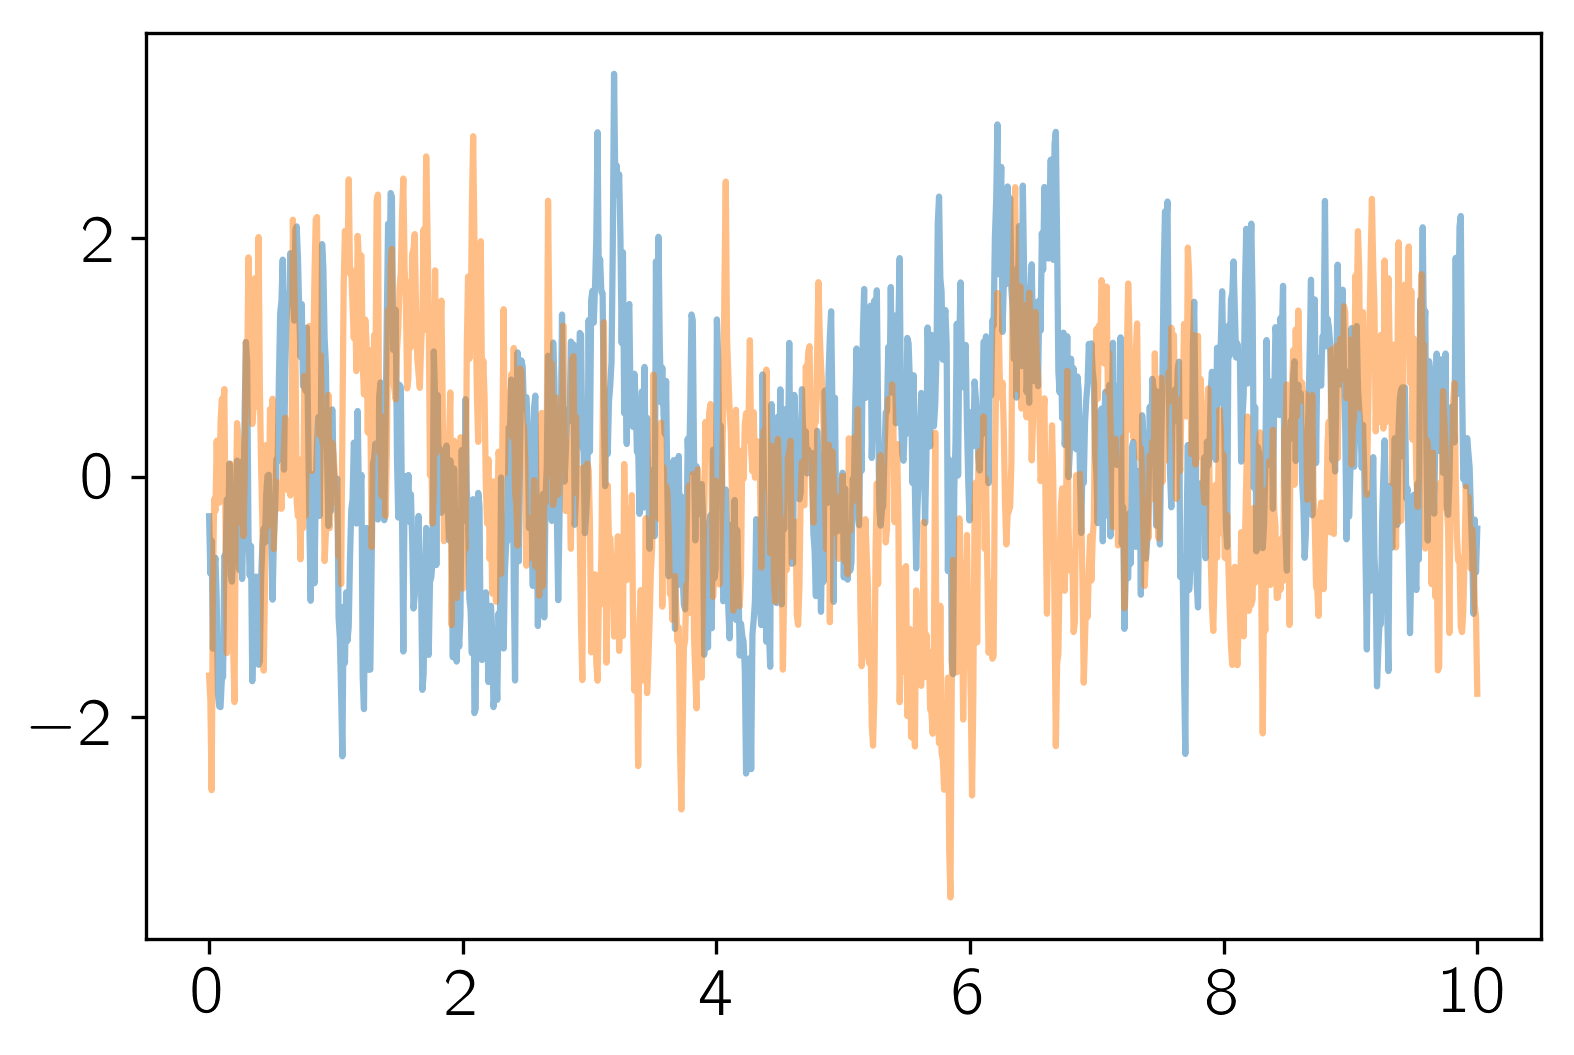

In [7]:
plt.plot(tinky,pinky,alpha=0.5);
plt.plot(tinky,pinky2,alpha=0.5);
# plt.plot(tinky[1:],np.diff(pinky),alpha=0.5);
# plt.plot(tinky[1:],np.diff(pinky2),alpha=0.5);
# plt.plot(tinky,ginky,alpha=0.5);

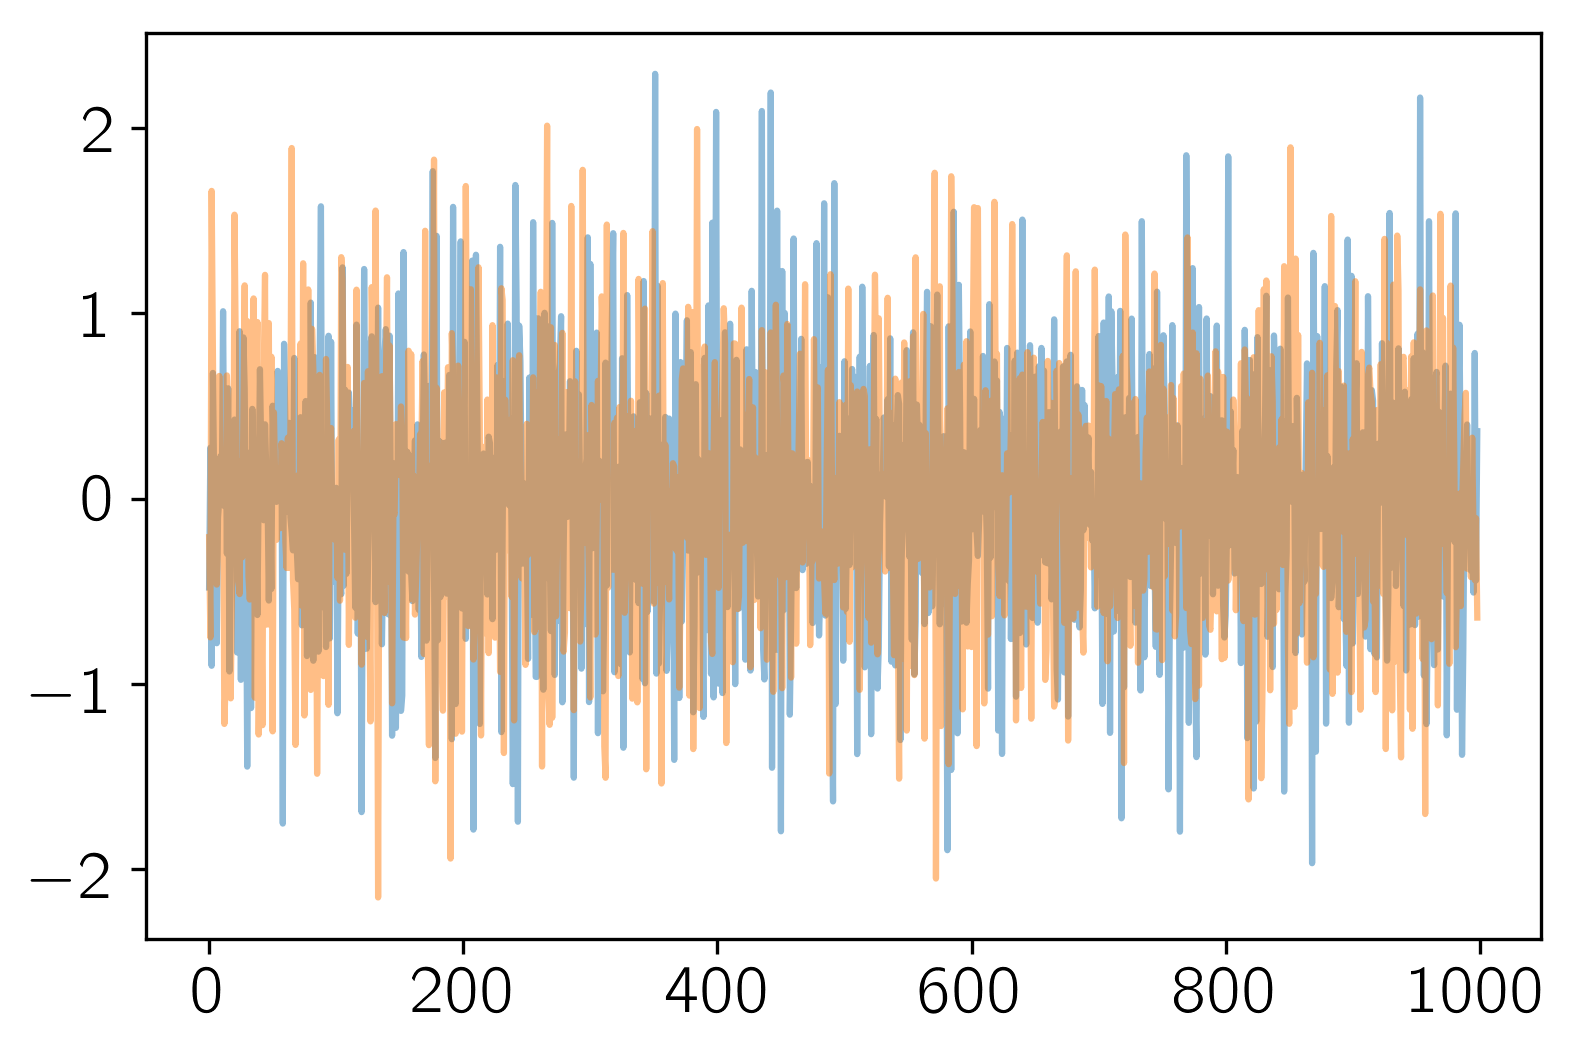

In [8]:
plot(diff(pinky),alpha=0.5);
plot(diff(pinky2),alpha=0.5);

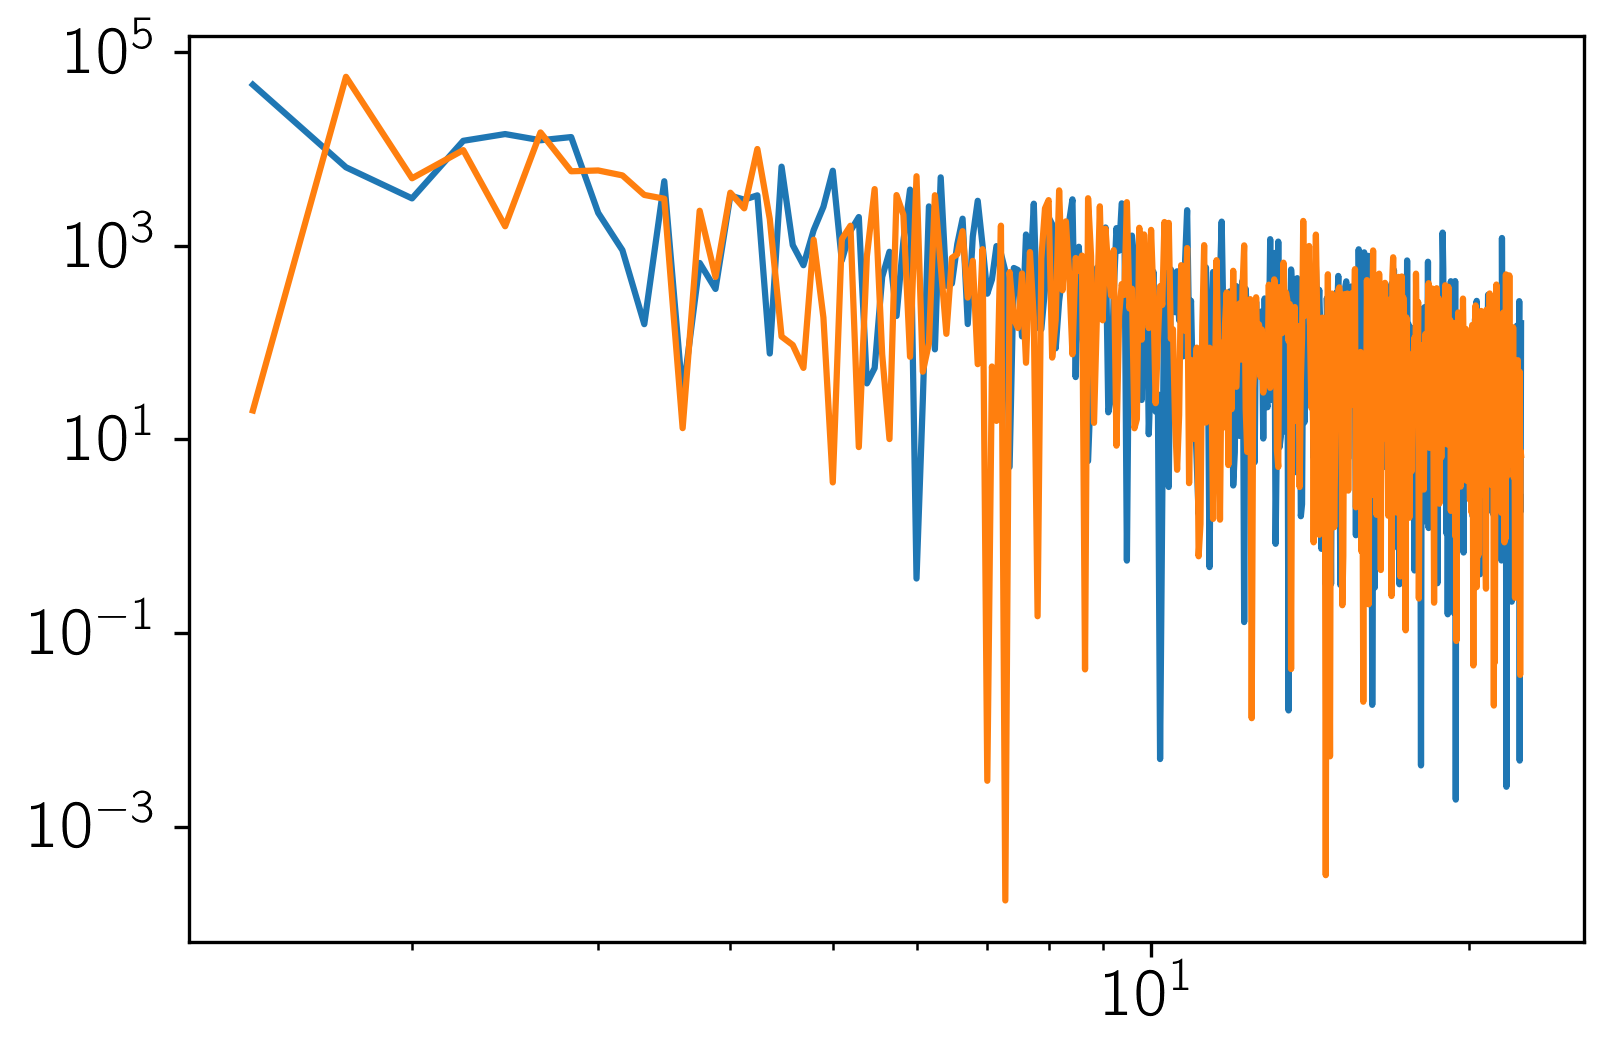

In [9]:
PSDinky = (np.fft.fftshift(np.fft.fft(pinky))[nPts//2:]).real**2
PSDinky2= (np.fft.fftshift(np.fft.fft(pinky2))[nPts//2:]).real**2
GSinky  = (np.fft.fftshift(np.fft.fft(ginky))[nPts//2:]).real**2
loglog(Sinky[1:],PSDinky);
loglog(Sinky[1:],PSDinky2);
# loglog(Sinky[1:],GSinky);

In [36]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)

logS0Range = -15, 15
logQRange  = -15, 15
logOmRange = -15, 15

bounds = dict(log_S0=logS0Range, log_Q=logQRange, log_omega0=logOmRange)

# kernelReal = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 0.3#.0
S0 = np.var(y) / (w0 * Q)
kernelSHO = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

kernel = kernelSHO #+ kernelReal

# # A periodic component
# Q = 1.0
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                         bounds=bounds)

In [37]:
t    = tinky
y    = pinky + np.linspace(0,t.max(),pinky.size)
yerr = yerrinky

<Container object of 3 artists>

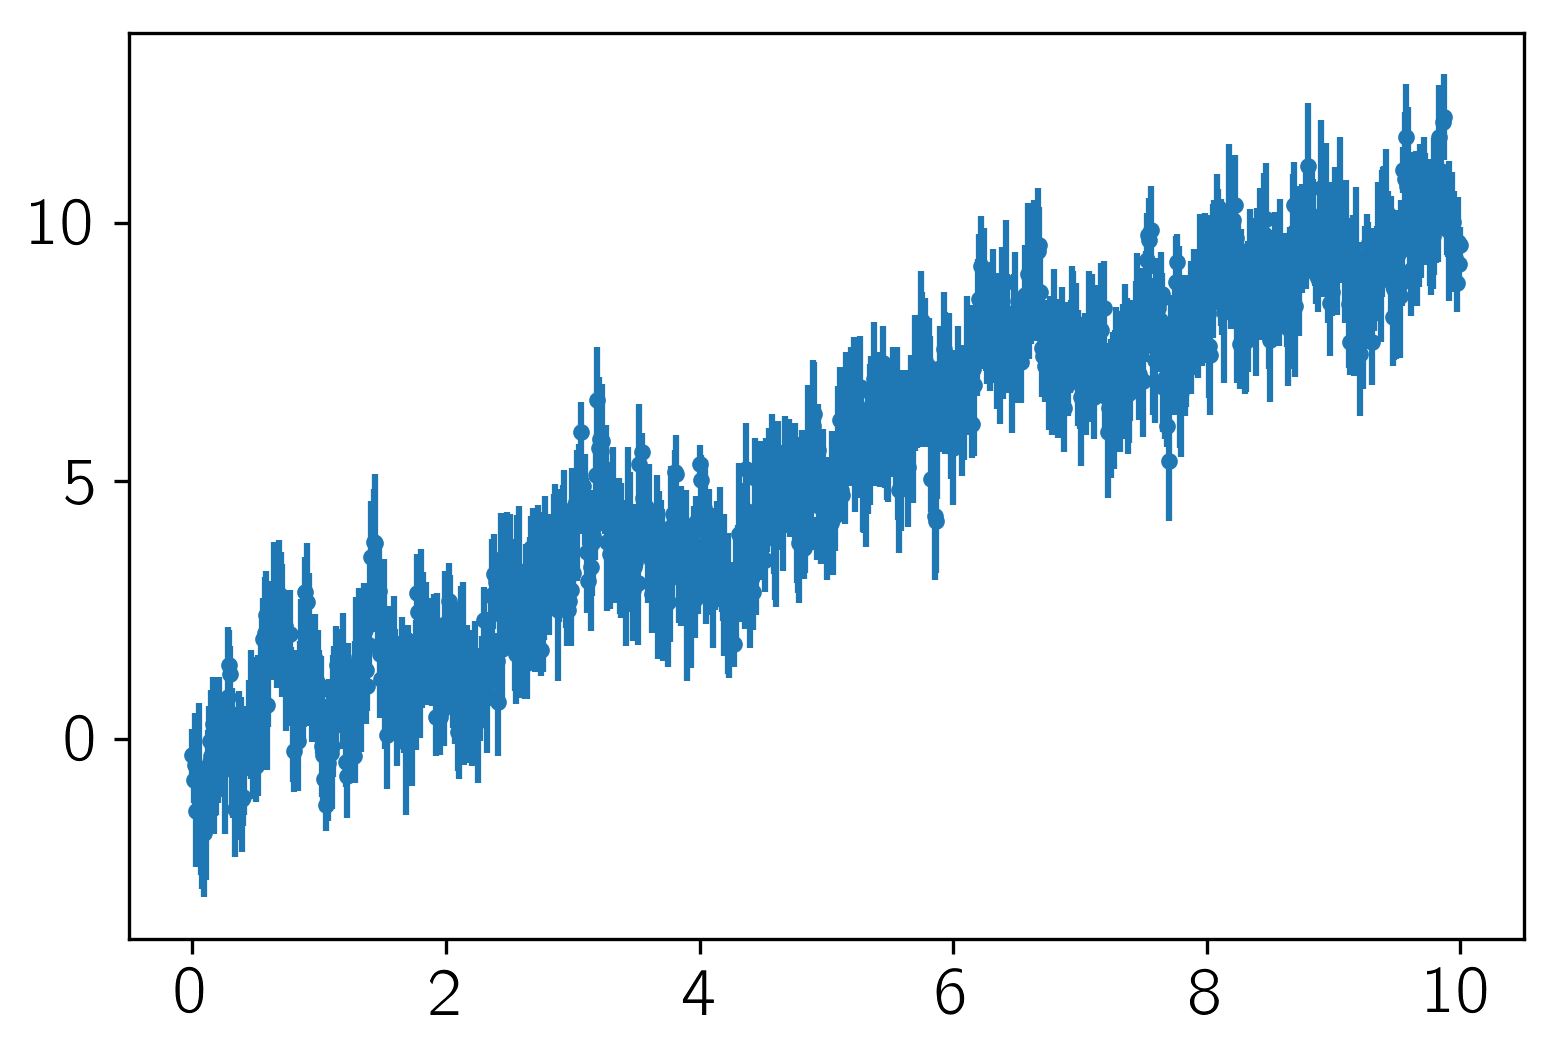

In [38]:
errorbar(t,y,yerr,fmt='.')

In [39]:
from scipy.optimize import minimize

cnt = 0
def neg_log_like(params, y, gp):
    global cnt
    cnt+=1
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

In [40]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
random_state  = 42
test_size     = 0.5

tTrain, tTest, yTrain, yTest, yerrTrain, yerrTest = train_test_split(t, y, yerr, test_size=test_size, random_state=random_state)

yTrain = yTrain[tTrain.argsort()]
yTest  = yTest[tTest.argsort()]

tTrain.sort()
tTest.sort()

In [41]:
gp = celerite.GP(kernel, mean=np.mean(yTrain))
gp.compute(tTrain, yerrTrain)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(yTrain)))

Initial log likelihood: -697.4554520972297


In [42]:
initial_params = gp.get_parameter_vector()
bounds         = gp.get_parameter_bounds()

start = time()
r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(yTrain, gp))
end = time()

gp.set_parameter_vector(r.x)
print()
print(r)
print()
print("Operation took {0:.2e} seconds and checked the LL {1:d} times".format(end-start, cnt))


      fun: 615.9562364170357
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00044338, -0.00086402, -0.00080718])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 18
   status: 0
  success: True
        x: array([ 5.28886686, -3.73930323,  1.42327646])

Operation took 4.42e-02 seconds and checked the LL 104 times


In [43]:
gp.compute(tTest, yerrTest)

nPtsBIG = 5000
x = np.linspace(tTest.min(), tTest.max(), nPtsBIG)
pred_mean, pred_var = gp.predict(yTest, x, return_var=True)
pred_std = np.sqrt(pred_var)

print(np.isnan(pred_mean).sum())

0


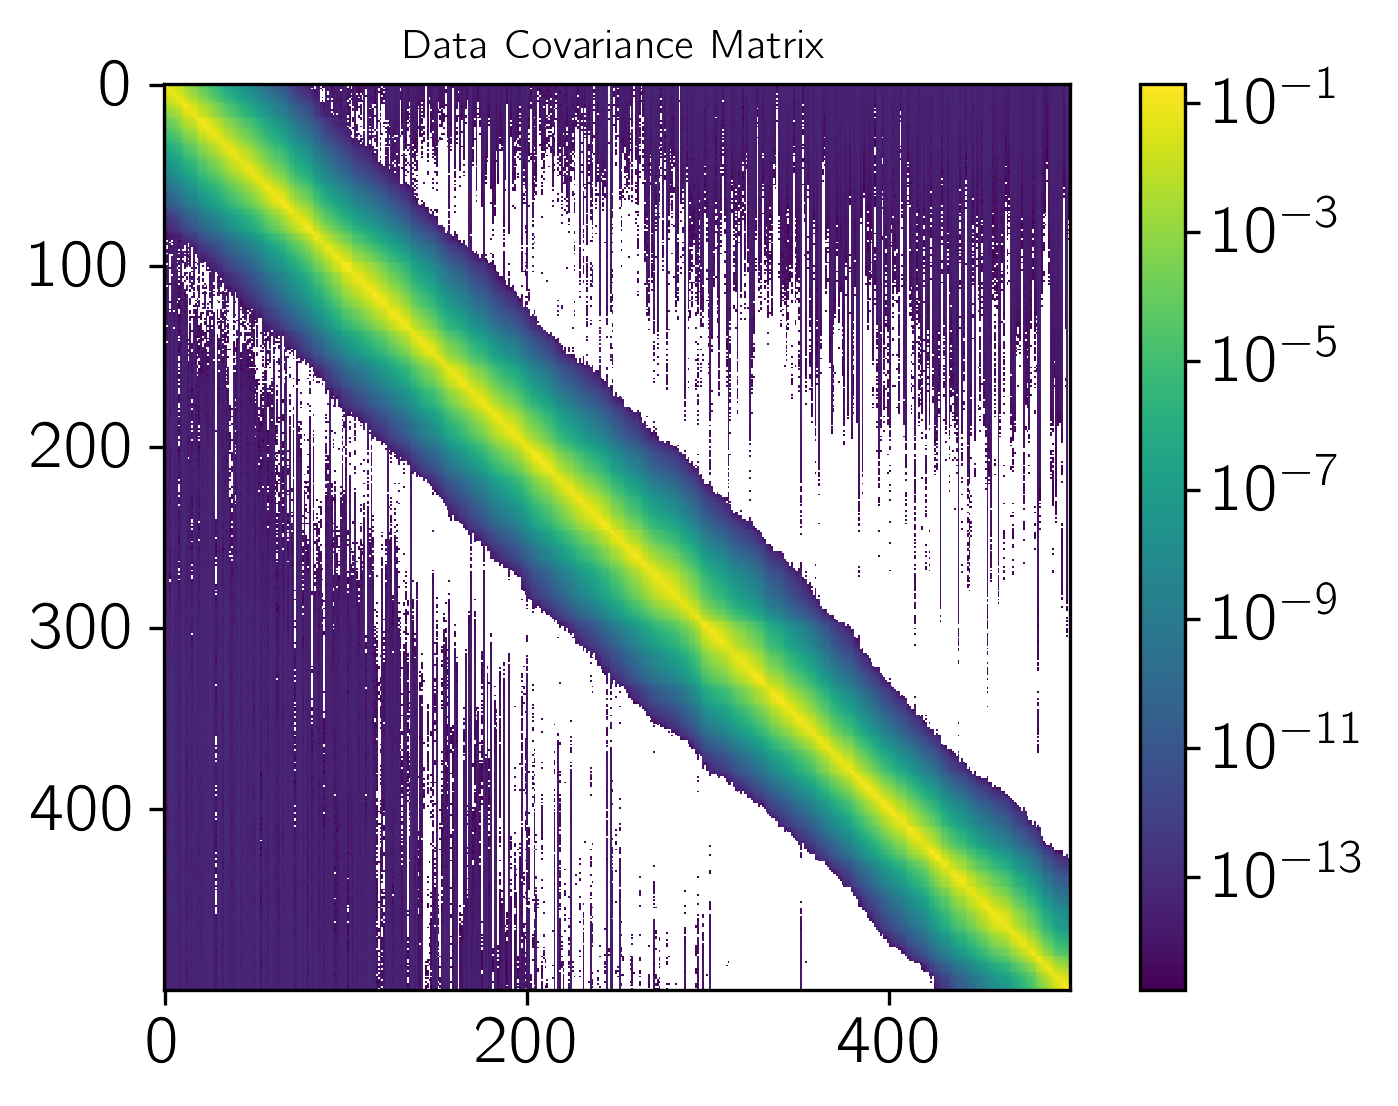

In [44]:
gp.compute(tTest, yerrTest)
pred_mean_Test2, pred_cov_Test2 = gp.predict(yTest, tTest)

imshow(pred_cov_Test2, norm=LogNorm());
title('Data Covariance Matrix',fontsize=10);
colorbar();

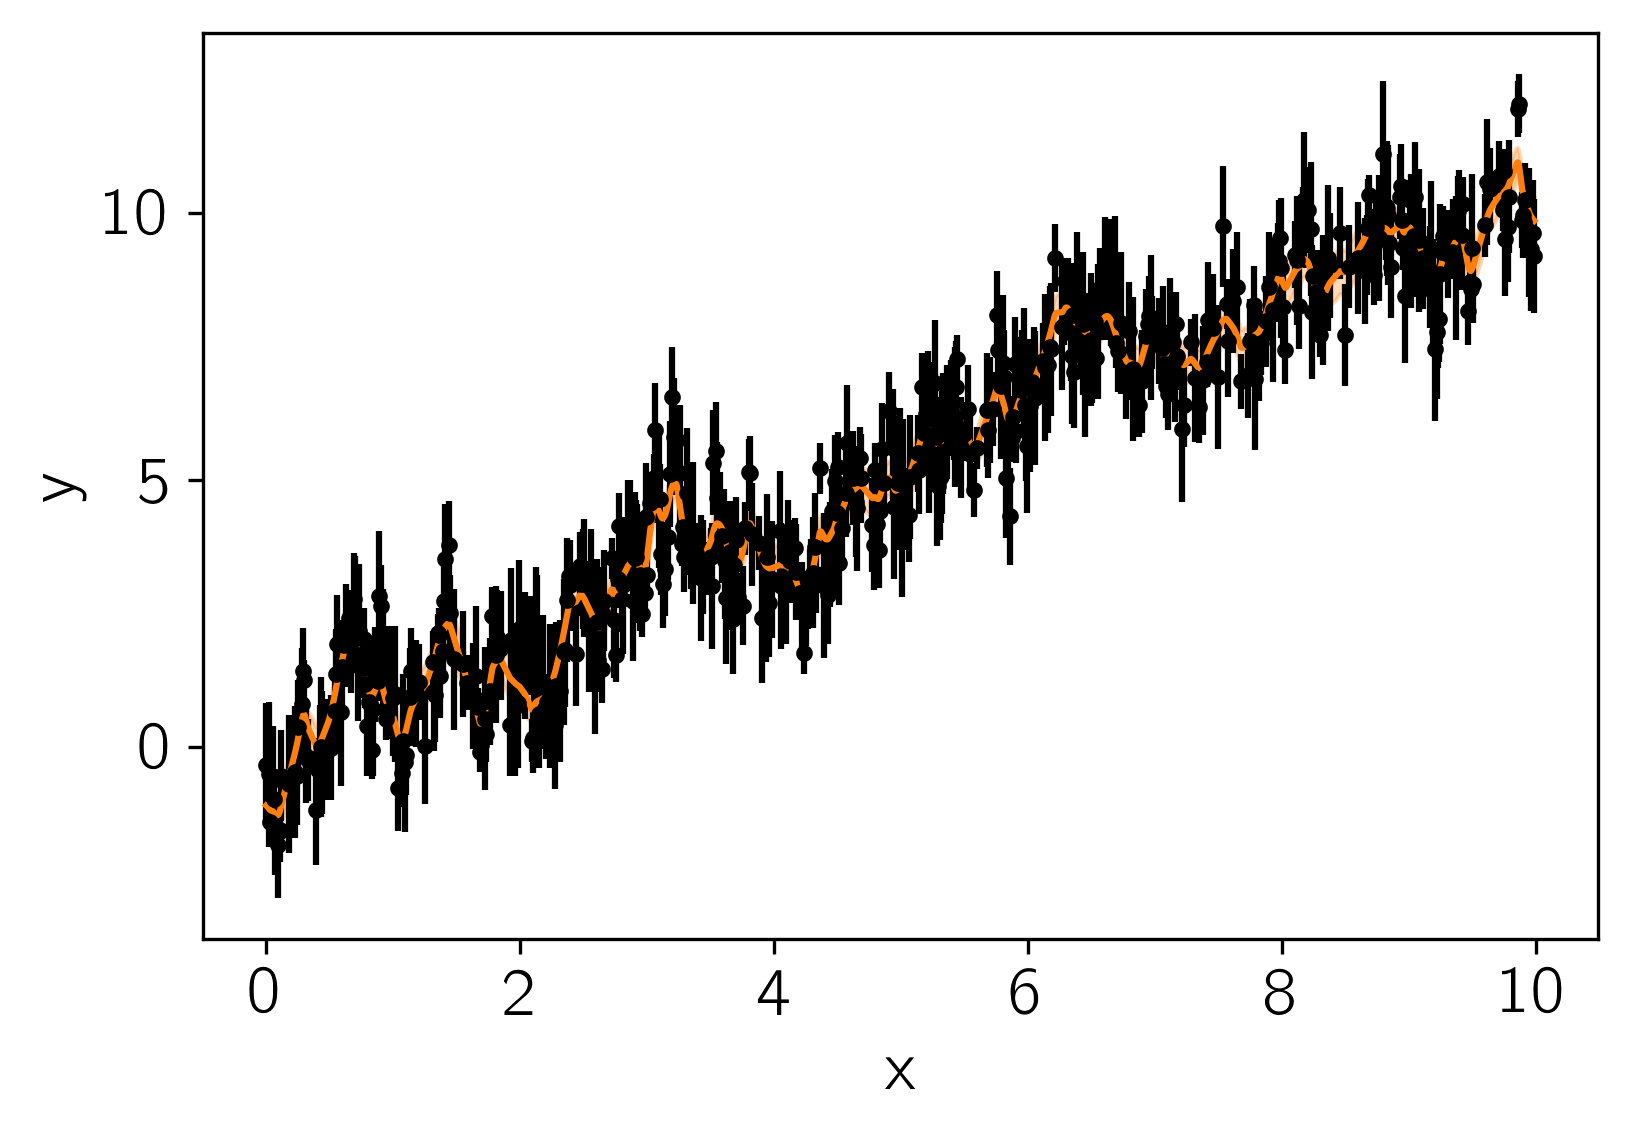

In [45]:
color = "#ff7f0e"
plt.errorbar(tTest, yTest, yerr=yerrTest, fmt=".k", capsize=0);
plt.plot(x, pred_mean, color=color);
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none");
plt.xlabel("x");
plt.ylabel("y");
# plt.xlim(0,10);
# plt.ylim(-2.5, 2.5);

**SciKit Learn Score Method**

$$R^2 = 1-\frac{u}{v}$$

with $T = y_{True}$ and $P = y_{Pred}$ such that

$$u = \sum_i^N (T_i - P_i)^2 \;\;\;\;\;\;\; \text{and} \;\;\;\;\;\;\;\; v = \sum_i^N (T_i - \bar{T})^2$$

The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred)^2).sum() and v is the residual sum of squares ((y_true - y_true.mean())^2).sum(). Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [46]:
def sklearn_score(y_true, y_pred):
    u = ((y_true - y_pred)**2).sum()
    v = ((y_true - y_true.mean())**2).sum()
    return 1 - u/v

In [47]:
gp.compute(tTrain,yerrTrain)
pred_mean_Train, pred_var_Train = gp.predict(yTrain, tTrain, return_var=True)
pred_std_Train = sqrt(pred_var_Train)

gp.compute(tTest,yerrTest)
pred_mean_Test, pred_var_Test   = gp.predict(yTest, tTest, return_var=True)
pred_std_Test = sqrt(pred_var_Test)

gp.compute(tinky, yerrinky)
pred_mean_2, pred_var_2   = gp.predict(pinky2+ np.linspace(0,tinky.max(),pinky2.size), tinky, return_var=True)
pred_std_2 = sqrt(pred_var_2)

randNoise = np.random.normal(0,pinkystd,tinky.size)
# gp.compute(tinky, yerrinky)
pred_mean_Rand, pred_var_Rand   = gp.predict(randNoise+ np.linspace(0,tinky.max(),pinky2.size) , tinky, return_var=True)
pred_std_Rand = sqrt(pred_var_Rand)

zerosArray = np.zeros(tinky.size)
# gp.compute(tinky, yerrinky)
pred_mean_Zero, pred_var_Zero   = gp.predict(zerosArray+ np.linspace(0,tinky.max(),pinky2.size), tinky, return_var=True)
pred_std_Zero = sqrt(pred_var_Zero)

print("Training R^2 Score:", sklearn_score(yTrain, pred_mean_Train))
print("Test     R^2 Score:", sklearn_score(yTest, pred_mean_Test))
print("Pinky2   R^2 Score:", sklearn_score(pinky2, pred_mean_2))
print("Rando    R^2 Score:", sklearn_score(randNoise, pred_mean_Rand))
print("Rando    R^2 Score:", sklearn_score(zerosArray, pred_mean_Zero))

Training R^2 Score: 0.969135417373
Test     R^2 Score: 0.967132489624
Pinky2   R^2 Score: -32.6884969465
Rando    R^2 Score: -61.7406409001
Rando    R^2 Score: -inf


/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


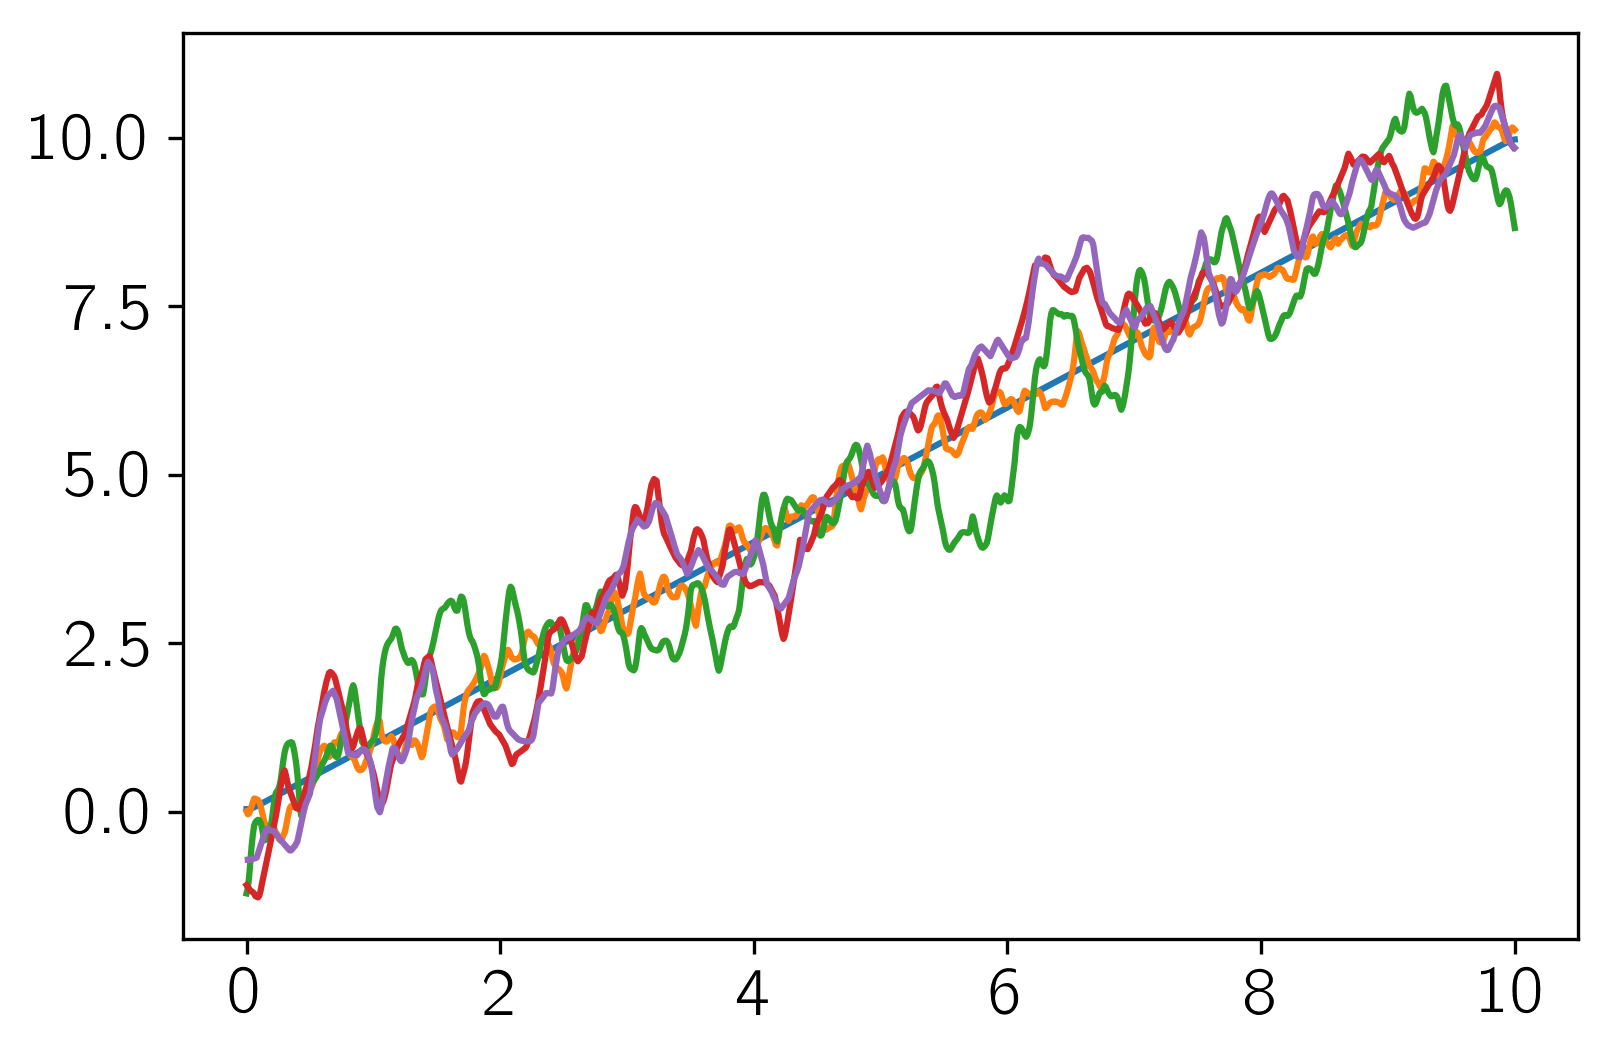

In [48]:
plot(tinky,pred_mean_Zero)
plot(tinky,pred_mean_Rand)
plot(tinky,pred_mean_2)
plot(tTest, pred_mean_Test)
plot(tTrain, pred_mean_Train)

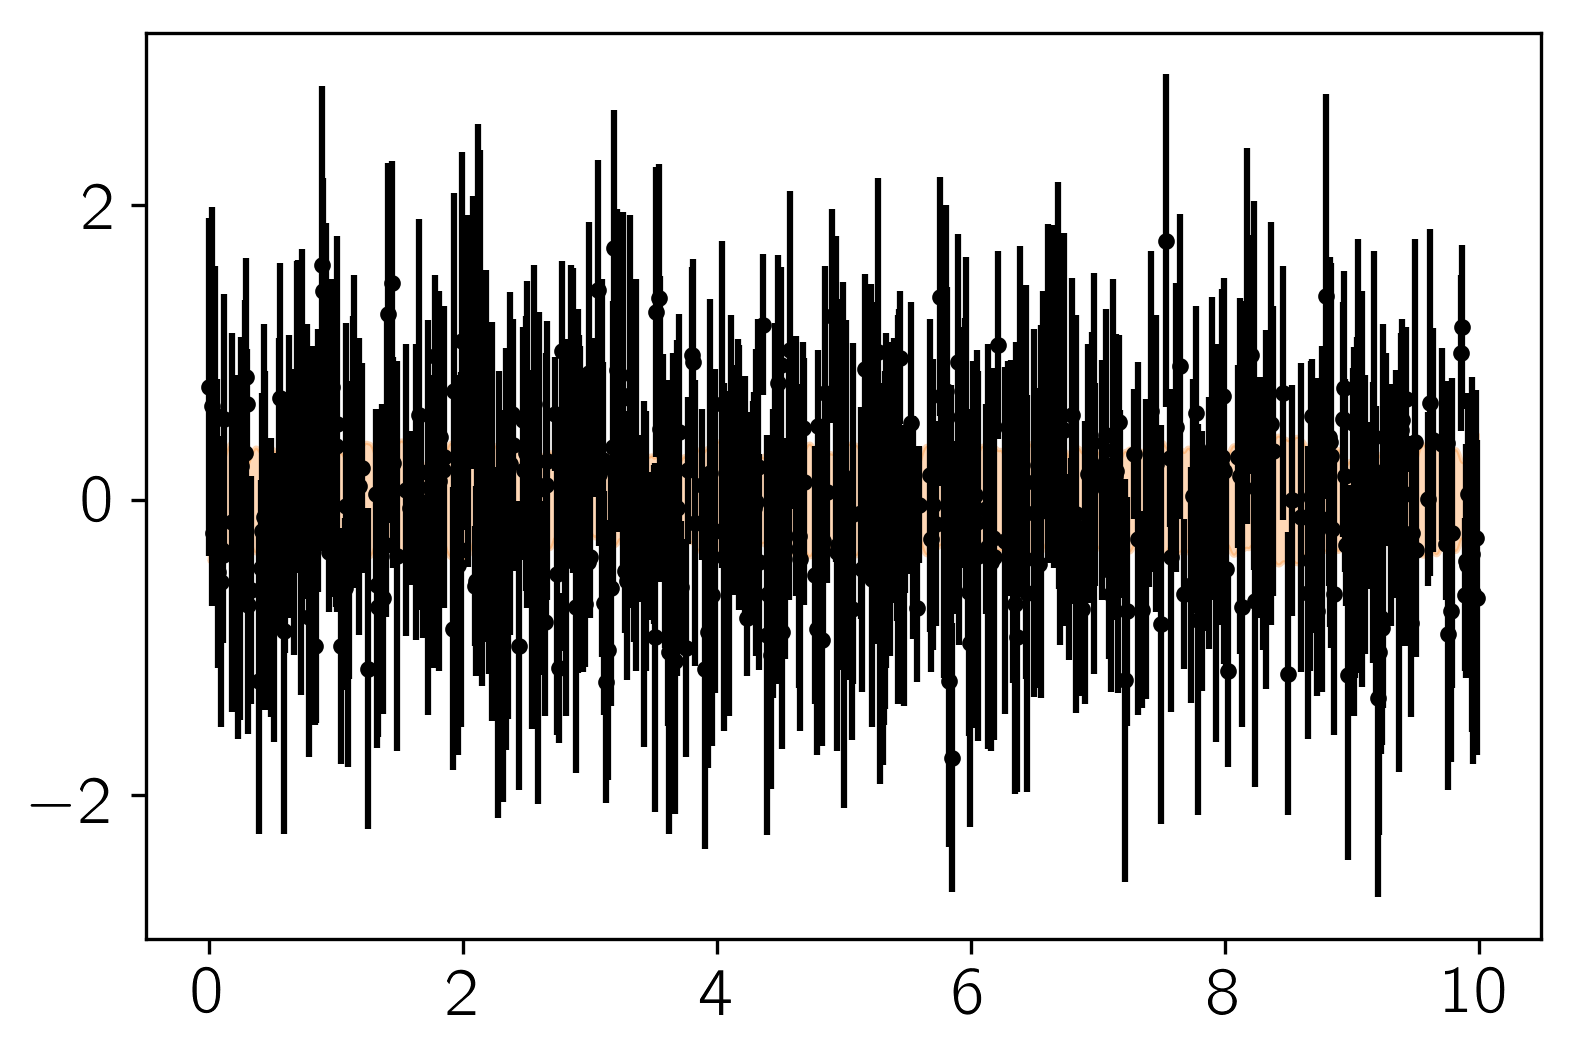

In [49]:
# pred_mean_data, pred_var_data = gp.predict(yTest, tTest, return_var=True)
plt.errorbar(tTest, yTest - pred_mean_Test, yerr=yerrTest, fmt=".k", capsize=0);
plt.fill_between(x, 0+pred_std, 0-pred_std, color=color, alpha=0.3, edgecolor="none");
# ylim(-2,2)
# xlim(0,2)

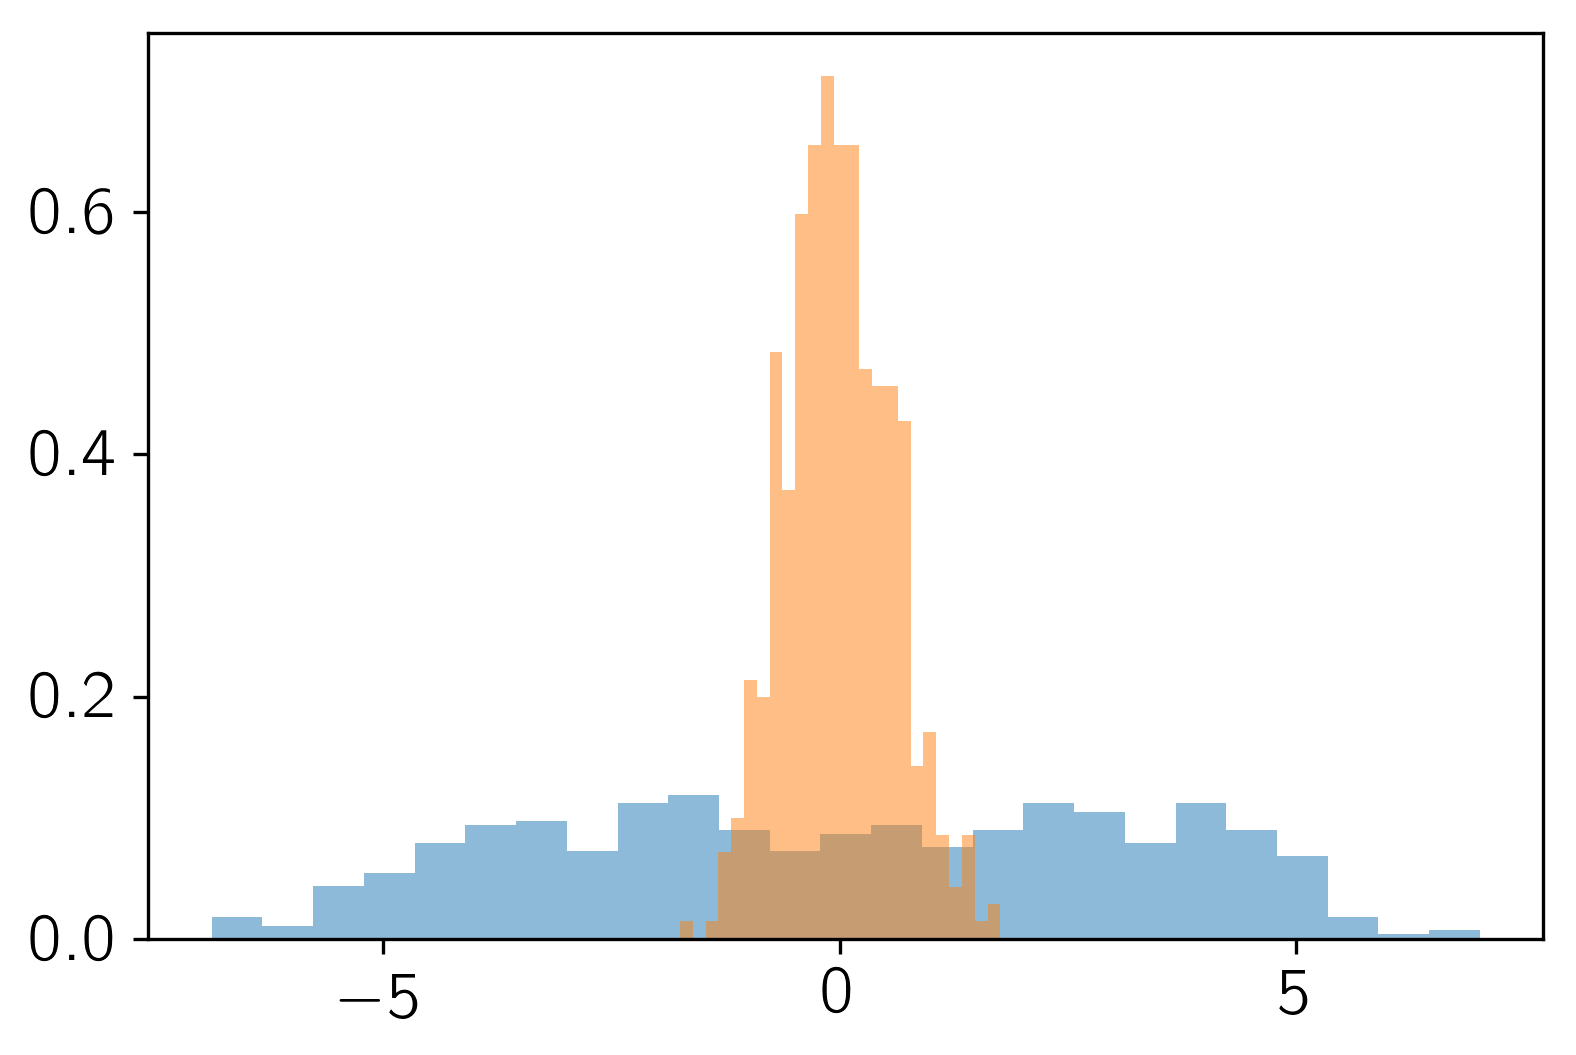

In [50]:
from astroML.plotting import hist
nbins = y.size//10
# hist(yTest-median(yTest), bins='blocks', normed=True, alpha=0.5);
# hist(yTest-pred_mean_Test, bins='blocks', normed=True, alpha=0.5);
hist(yTest-median(yTest), bins=tTest.size//20, normed=True, alpha=0.5);
hist(yTest-pred_mean_Test, bins=tTest.size//20, normed=True, alpha=0.5);

# xlim(-2,2);

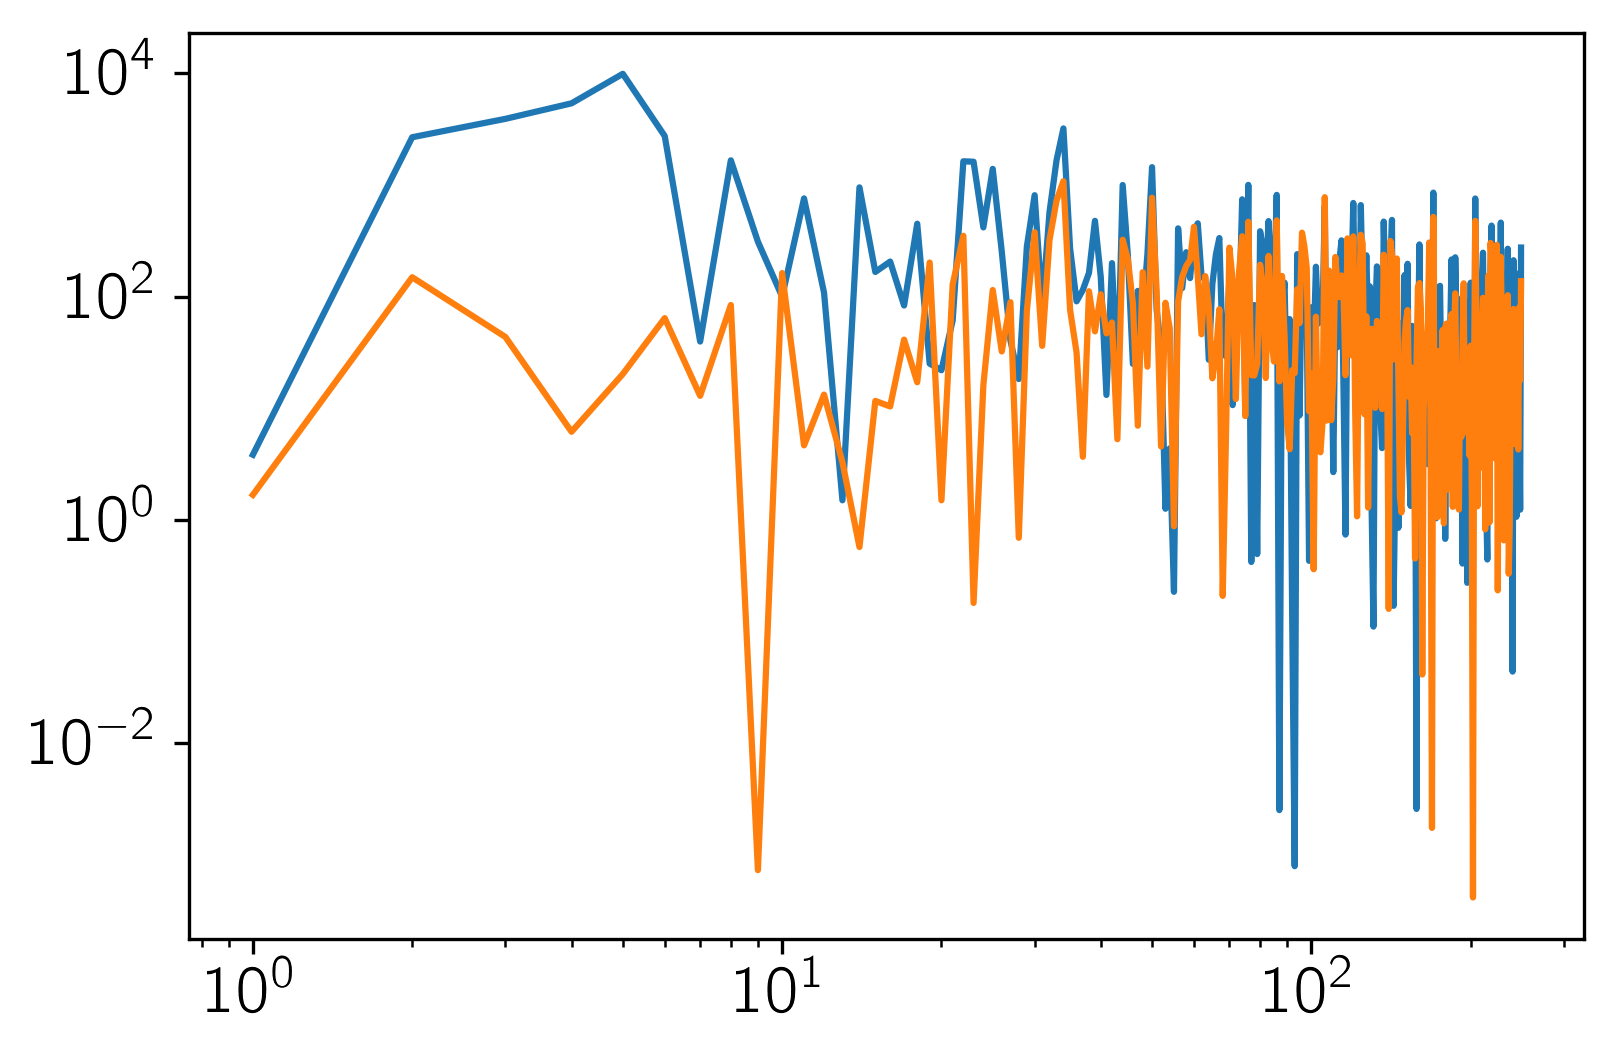

In [51]:
PSDinky = (np.fft.fftshift(np.fft.fft(yTest-median(yTest)))[yTest.size//2:]).real**2
PSDRes= (np.fft.fftshift(np.fft.fft(yTest - pred_mean_Test))[yTest.size//2:]).real**2
loglog(PSDinky);
loglog(PSDRes);

In [52]:
from scipy.stats import linregress

xlog    = np.log10(np.arange(PSDRes.size)+1.000001)
lr_res  = linregress(xlog, log10(PSDRes))
lr_init = linregress(xlog, log10(PSDinky))

print('init:\t\t', lr_init.slope, lr_init.intercept)
print('residuals:\t', lr_res.slope, lr_res.intercept)

init:		 -0.877667896923 3.3636643089
residuals:	 -0.13145514554 1.62953163703


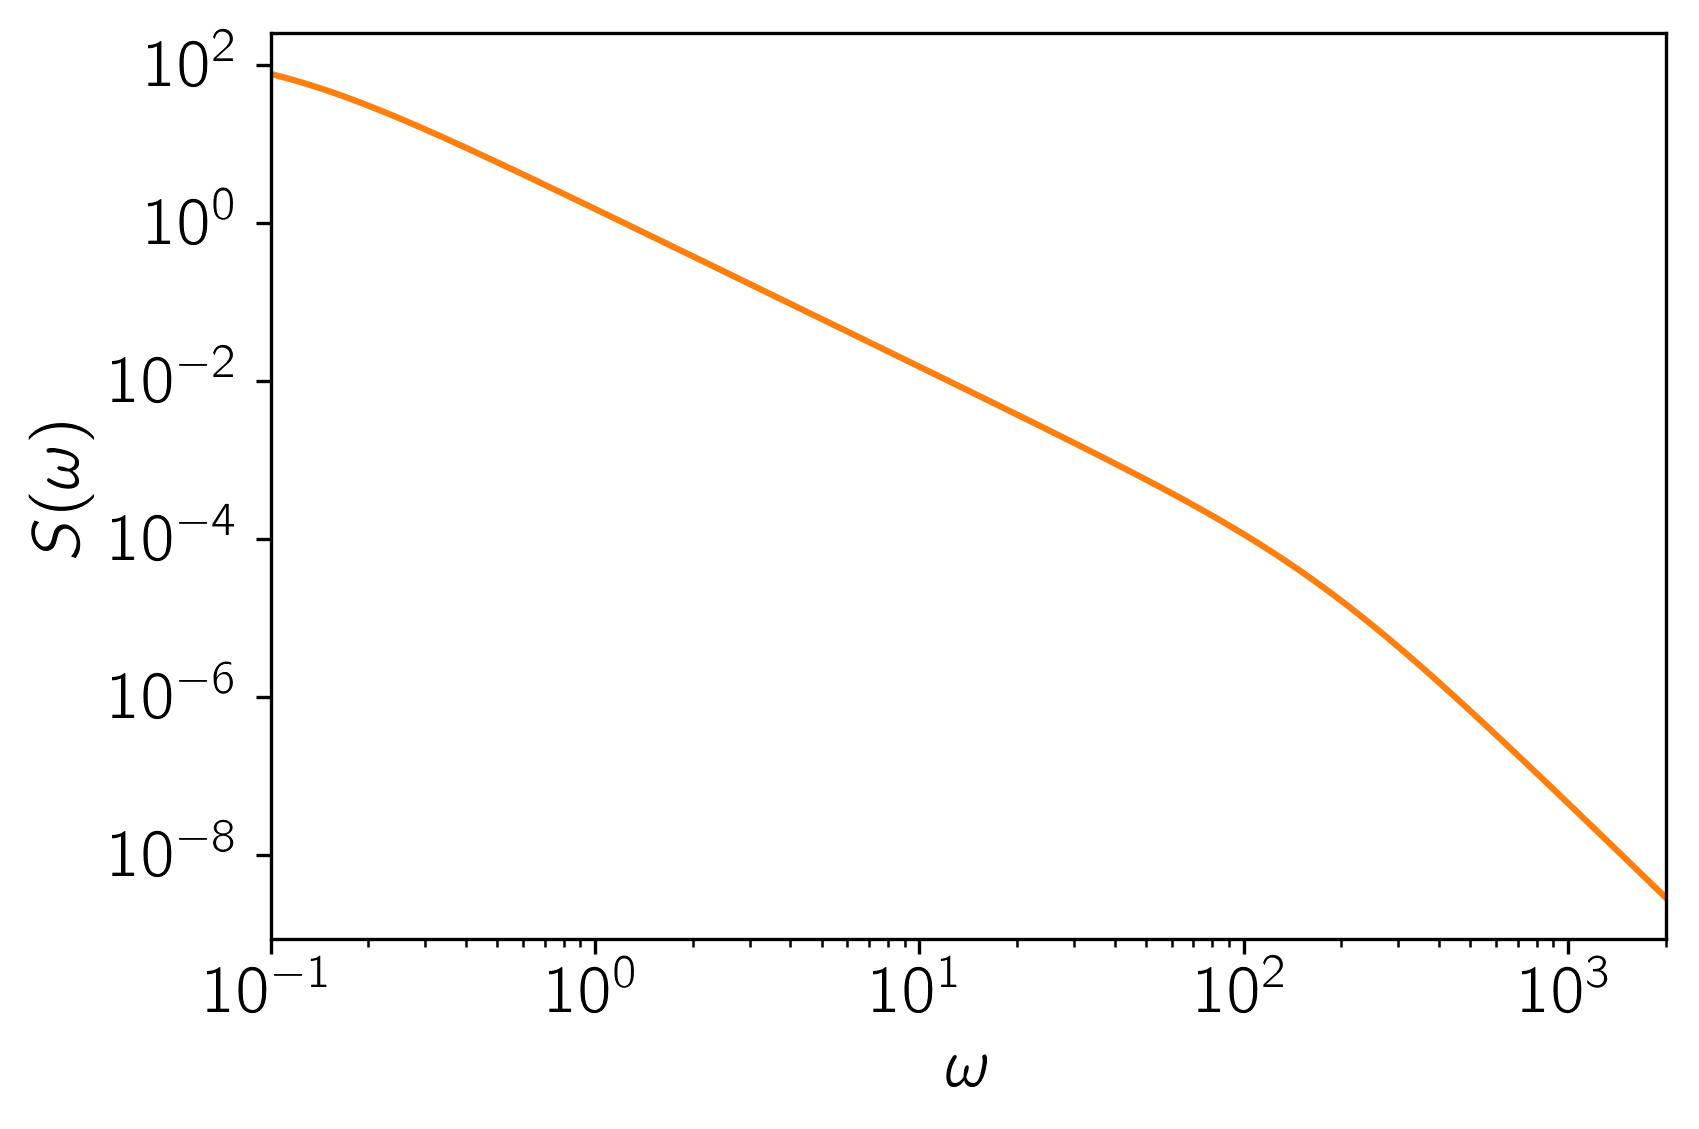

In [53]:
# from ExoWanderer.auxiliary import smooth_gaussconv

omega = np.exp(np.linspace(np.log(1e-1), np.log(2e3), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
# plt.plot(Sinky[1:PSDinky.size+1][:246],smooth_gaussconv(PSDinky/(PSDinky.size-1)**2,2)[:246]);
# for k in gp.kernel.terms:
#     plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

# Gaussian Process to Fit Gaussian Model [no relation]

**Gaussian Processes for 1D Gaussian Fitting**

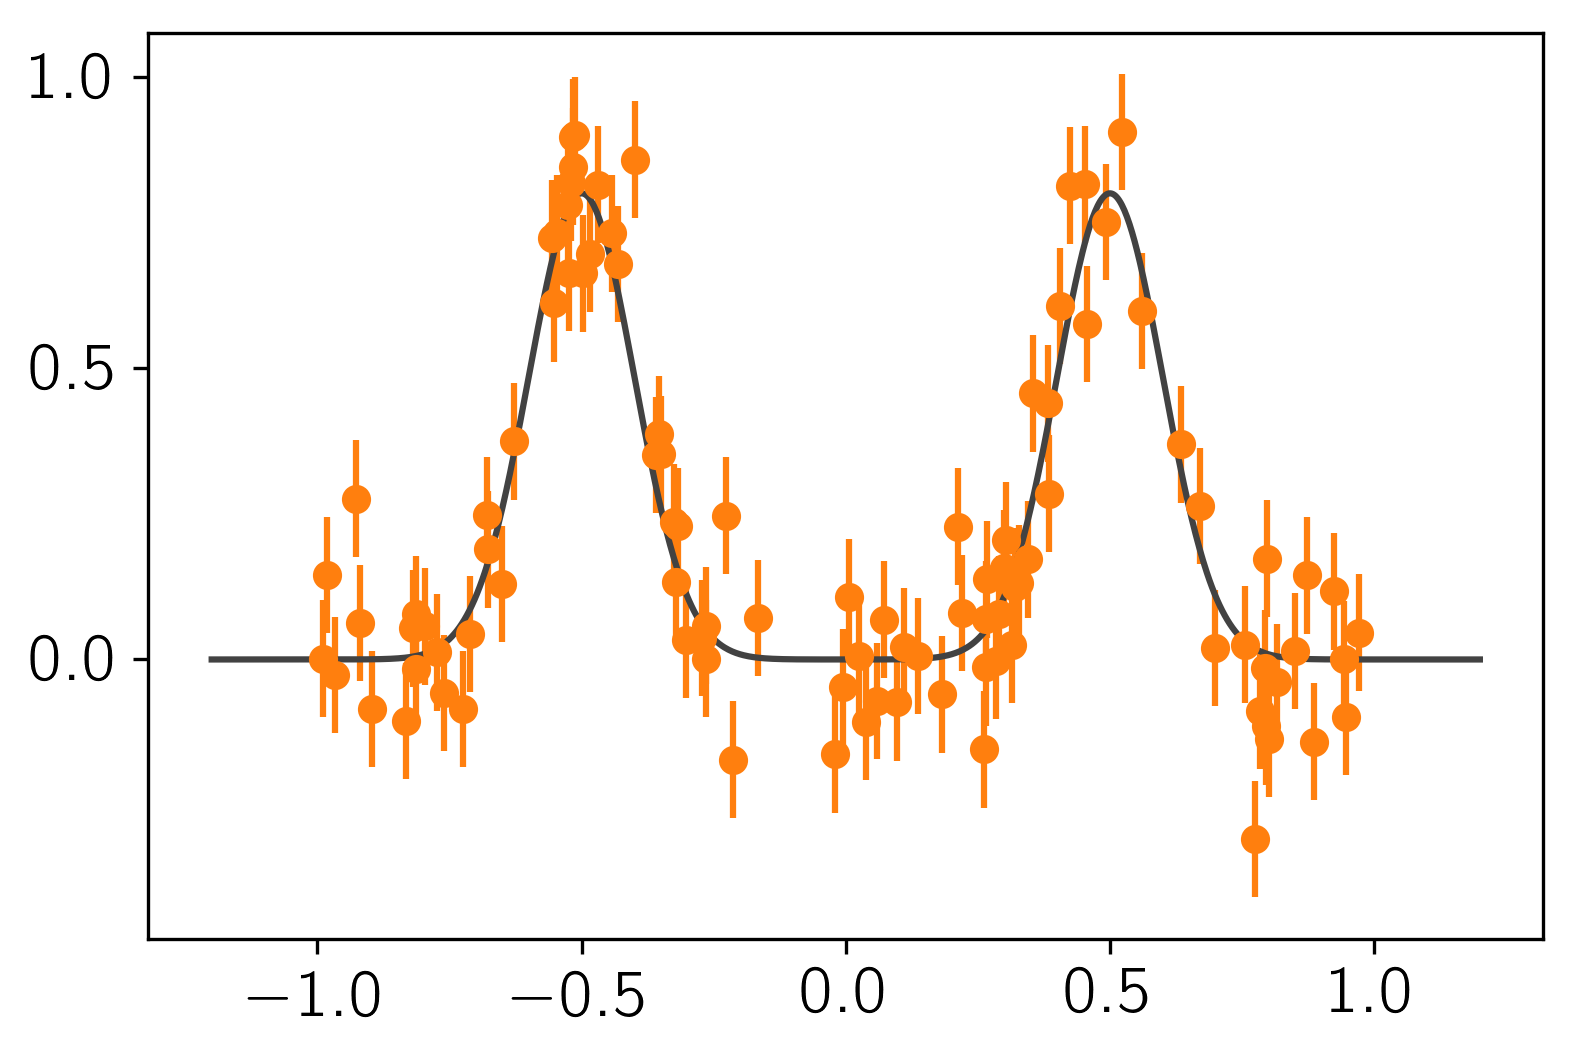

In [54]:
def gaussian1Dp(cube):
    center = cube[0]
    width  = cube[1]
    height = cube[2]
    return lambda y: height*np.exp(-0.5*(( (center - y) / width)**2))# / sqrt(2*pi*width**2)

def gaussian1D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y: np.exp(-0.5*(( (center - y) / width)**2)) / sqrt(2*pi*width**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0a= -0.5#0.05
param0b= 0.5#0.05
param1a= 0.1#5*pi
param1b= 0.1#5*pi
param2a= 0.8
param2b= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -1#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave; parameters = ["amp", "period"]
# model = straight_line; parameters = ["offset", "slope"]
# model = gaussian1D; parameters = ["center", "width"]
model = gaussian1Dp; parameters = ["center", "width", "height"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
true_t= np.linspace(xmin-dx, xmax+dx, nThPts)

# xdata = np.linspace(xmin,xmax,nPts)
t = sort(np.random.uniform(xmin, xmax, nPts))
ydata = model([param0a,param1a,param2a])(t) + model([param0b,param1b,param2b])(t)

yerr  = np.random.normal(0, yuncs, nPts)
y = yerr + ydata# + yerr

true_y  = model([param0a,param1a,param2a])(true_t) + model([param0b,param1b,param2b])(true_t)

figure()#figsize=(10,10));
plot(true_t, true_y, color="#424242");
errorbar(t, y, yunc*ones(y.size), fmt='o', color = "#ff7f0e");

**SHOTerm PSD**

$$S(\omega) = \sqrt{\frac{2}{\pi}} \frac{S_0\,\omega_0^4}
    {(\omega^2-{\omega_0}^2)^2 + {\omega_0}^2\,\omega^2/Q^2}$$
    
**Real Term PSD**
$$k(\tau) = a_j\,e^{-c_j\,\tau}$$

In [ ]:
import celerite
from celerite import terms

# A non-periodic component
Q  = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_a=(-15, 15), log_c=(-15, 15))
kernelR = terms.RealTerm(log_a=np.log(S0), log_c=np.log(Q),bounds=bounds)
kernelS = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

kernelS.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# # A periodic component
# Q = 1.0
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# kernelRS = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)+\
#            terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

In [ ]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
boundsRS = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernelRS = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernelRS.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernelRS += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [ ]:
gpR = celerite.GP(kernelR, mean=np.mean(y))
gpR.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gpR.log_likelihood(y)))

gpS = celerite.GP(kernelS, mean=np.mean(y))
gpS.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gpS.log_likelihood(y)))

gpRS = celerite.GP(kernelRS, mean=np.mean(y))
gpRS.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gpRS.log_likelihood(y)))

In [ ]:
print("REAL")
print("parameter_dict:\n{0}\n".format(gpR.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gpR.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gpR.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gpR.get_parameter_bounds()))
print()
print("SHO")
print("parameter_dict:\n{0}\n".format(gpS.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gpS.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gpS.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gpS.get_parameter_bounds()))
print()
print("R+SHO")
print("parameter_dict:\n{0}\n".format(gpRS.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gpRS.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gpRS.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gpRS.get_parameter_bounds()))

In [ ]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gsnow = gaussian1Dp(params[:2])
    gp.set_parameter_vector(params[2:])
    return -gp.log_likelihood(y-gsnow)

# def neg_log_likeR(params, y, gp):
#     gpR.set_parameter_vector(params)
#     return -gpR.log_likelihood(y)

# def neg_log_likeS(params, y, gp):
#     gpS.set_parameter_vector(params)
#     return -gpS.log_likelihood(y)

# def neg_log_likeRS(params, y, gp):
#     gpS.set_parameter_vector(params)
#     return -gpS.log_likelihood(y)

initial_paramsR = gpR.get_parameter_vector()
initial_paramsS = gpS.get_parameter_vector()
initial_paramsRS = gpRS.get_parameter_vector()
boundsR = gpR.get_parameter_bounds()
boundsS = gpS.get_parameter_bounds()
boundsRS = gpRS.get_parameter_bounds()

rR = minimize(neg_log_like, initial_paramsR , method="L-BFGS-B", bounds=boundsR , args=(y, gpR ))
rS = minimize(neg_log_like, initial_paramsS , method="L-BFGS-B", bounds=boundsS , args=(y, gpS ))
rRS= minimize(neg_log_like, initial_paramsRS, method="L-BFGS-B", bounds=boundsRS, args=(y, gpRS))

gpR.set_parameter_vector(rR.x)
gpS.set_parameter_vector(rS.x)
gpRS.set_parameter_vector(rRS.x)
print(rR)
print()
print(rS)
print()
print(rRS)

In [ ]:
gpR.get_parameter_dict(),gpS.get_parameter_dict(),gpRS.get_parameter_dict()

In [ ]:
x = np.linspace(-1.1, 1.1, 1000)
pred_meanR, cov_varR = gpR.predict(y, x)
pred_meanR, pred_varR = gpR.predict(y, x, return_var=True)
pred_stdR = np.sqrt(pred_varR)

pred_meanS, cov_varS = gpS.predict(y, x)
pred_meanS, pred_varS = gpS.predict(y, x, return_var=True)
pred_stdS = np.sqrt(pred_varS)

pred_meanRS, cov_varRS = gpRS.predict(y, x)
pred_meanRS, pred_varRS = gpRS.predict(y, x, return_var=True)
pred_stdRS = np.sqrt(pred_varRS)

In [ ]:
figure()
imshow(cov_varS);
colorbar()
title('S Data Covariance Matrix');

figure()
imshow(cov_varR);
colorbar()
title('R Data Covariance Matrix');

figure()
imshow(cov_varRS);
colorbar()
title('RS Data Covariance Matrix');

In [ ]:
figure()
_, cov_var_dataS = gpS.predict(y, t)
imshow(cov_var_dataS);
colorbar()
title('S Data Covariance Matrix');

figure()
_, cov_var_dataR = gpR.predict(y, t)
imshow(cov_var_dataR);
colorbar()
title('R Data Covariance Matrix');

figure()
_, cov_var_dataRS = gpRS.predict(y, t)
imshow(cov_var_dataRS);
colorbar()
title('RS Data Covariance Matrix');

In [ ]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_meanS, color=color)
plt.fill_between(x, pred_meanS+pred_stdS, pred_meanS-pred_stdS, color=color, alpha=0.3,
                 edgecolor="none")

# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_meanR, color='violet')
plt.fill_between(x, pred_meanR+pred_stdR, pred_meanR-pred_stdR, color='violet', alpha=0.3,
                 edgecolor="none")

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_meanRS, color='gold')
plt.fill_between(x, pred_meanRS+pred_stdRS, pred_meanRS-pred_stdRS, color='gold', alpha=0.3,
                 edgecolor="none")

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1.1,1.1)
plt.ylim(-0.5, 1.25);

figure()
plt.semilogy(true_t, abs(true_y-pred_meanS)/true_y, c=color   )
plt.semilogy(true_t, abs(true_y-pred_meanR)/true_y, c="violet")
plt.semilogy(true_t, abs(true_y-pred_meanRS)/true_y, c="gold")

In [ ]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psdR = gpR.kernel.get_psd(omega)
psdS = gpS.kernel.get_psd(omega)
psdRS= gpRS.kernel.get_psd(omega)

plt.plot(omega, psdR , color=color)
plt.plot(omega, psdS , color="violet")
plt.plot(omega, psdRS, color="gold")

for k in gpR.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

for k in gpS.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

for k in gpRS.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

** MultiModel Gaussian Normal in 1D**

In [ ]:
def gaussian1Dp(cube):
    center = cube[0]
    width  = cube[1]
    height = cube[2]
    return lambda y: height*np.exp(-0.5*(( (center - y) / width)**2))# / sqrt(2*pi*width**2)

def gaussian1D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y: np.exp(-0.5*(( (center - y) / width)**2)) / sqrt(2*pi*width**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0a= -0.5#0.05
param0b= 0.5#0.05
param1a= 0.1#5*pi
param1b= 0.1#5*pi
param2a= 0.8
param2b= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -1#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave; parameters = ["amp", "period"]
# model = straight_line; parameters = ["offset", "slope"]
# model = gaussian1D; parameters = ["center", "width"]
model = gaussian1Dp; parameters = ["center", "width", "height"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
true_t= np.linspace(xmin-dx, xmax+dx, nThPts)

# xdata = np.linspace(xmin,xmax,nPts)
t = sort(np.random.uniform(xmin, xmax, nPts))
ydata = model([param0a,param1a,param2a])(xdata) + model([param0b,param1b,param2b])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
y = ydata + yerr

true_y  = model([param0a,param1a,param2a])(thdata) + model([param0b,param1b,param2b])(thdata)

figure(figsize=(10,10));
plot(true_t, true_y);
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o');

In [ ]:
def prior(cube, ndim, nparams):
    cube[0] = cube[0]*2 - 1
    cube[1] = cube[1]*2
    cube[2] = cube[2]*2
    pass

def loglike(cube, ndim, nparams):
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))

# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename=outputfiles_basename); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(loglike, prior, n_params, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'parameter', n_live_points = 1000, outputfiles_basename=outputfiles_basename)

'''
sampling_efficiency == 'parameter' for parameter estimation
sampling_efficiency == 'model'     for model selection
'''

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=outputfiles_basename)
s = a.get_stats()

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3))

print('True a\t', [param0a, param1a])
print('True b\t', [param0b, param1b])

In [ ]:
p.analyser.get_stats()

In [ ]:
figure(figsize=(10,10))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
modelAll = np.zeros(thdata.size)
for m in p.analyser.get_stats()['modes']:
    modelAll = modelAll + model(m['mean'])(thdata)
    plot(thdata, model(m['mean'])(thdata))

plot(thdata, modelAll)
plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))

** Simple MultiModel Gaussian Normal in 2D**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian2D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y,x: np.exp(-0.5*((( (center - y) / width)**2) + (( (center - x) / width)**2))) / sqrt(2*pi*width**2)

np.random.seed(42)

param0a= 0.75#0.05
param1a= 0.05#0.05
param0b= 0.25#0.05
param1b= 0.05#0.05

# param2= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -0#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

ymin  = -0#*pi
ymax  =  1#*pi
dy    = 0.1*(ymax - ymin)

model = gaussian2D; parameters = ["center", "width"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, (nPts,nPts))
# thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.ones((nPts,nPts))*np.linspace(xmin,xmax,nPts)
ydata = (np.ones((nPts,nPts))*np.linspace(ymin,ymax,nPts)).T

zmodel  = model([param0a,param1a])(ydata,xdata) + model([param0b,param1b])(ydata,xdata)
zerr    = np.random.normal(0, yuncs, (nPts,nPts))
zdata   = zmodel + zerr

figure(figsize=(10,10))
imshow(zdata, extent=[xdata.min(), xdata.max(), ydata.min(), ydata.max()])

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def prior(cube, ndim, nparams):
    pass

def loglike(cube, ndim, nparams):
    modelNow = gaussian2D(cube)(ydata,xdata)
    return -0.5*((modelNow - zdata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename=outputfiles_basename); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(loglike, prior, n_params, importance_nested_sampling = False, \
                resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
                outputfiles_basename=outputfiles_basename)

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=outputfiles_basename)
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3),'\t', np.round(mode['local log-evidence'],3))

print('True a\t', [param0a, param1a])
print('True b\t', [param0b, param1b])

In [ ]:
modelAll = np.zeros((nPts, nPts))
fig=figure(figsize=(20,10))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    modelAll = modelAll + model(mode['mean'])(ydata,xdata)
    ax = fig.add_subplot(1,len(p.analyser.get_stats()['modes']), km+1)
    ims = ax.imshow(model(mode['mean'])(ydata,xdata))
    plt.colorbar(ims)

fig = figure(figsize=(20,10))
ax = fig.add_subplot(131)
ims = ax.imshow(modelAll)
plt.colorbar(ims)
ax = fig.add_subplot(132)
ims = ax.imshow(model(p.analyser.get_best_fit()['parameters'])(ydata,xdata))
plt.colorbar(ims)
ax = fig.add_subplot(133)
ims = ax.imshow(zdata)
plt.colorbar(ims)

# Residuals
modelAll = np.zeros((nPts, nPts))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    if np.round(mode['local log-evidence'],3) > -400000.:
        modelAll = modelAll + model(mode['mean'])(ydata,xdata)

fig = figure(figsize=(20,10))
ax  = fig.add_subplot(131)
ims = ax.imshow(zdata - modelAll)
plt.colorbar(ims)
ax  = fig.add_subplot(132)
ax.hist((zdata - modelAll).ravel(), bins=1000, normed=True);
# plt.colorbar(ims)

In [ ]:
p.analyser.get_stats()

** Full MultiModel Gaussian Normal in 2D**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian2D(cube):
    ycenter = cube[0]
    xcenter = cube[1]
    ywidth  = cube[2]
    xwidth  = cube[3]
    height  = cube[4]
    offset  = cube[5]
    return lambda y,x: height*np.exp(-0.5*((( (ycenter - y) / ywidth)**2) + (( (xcenter - x) / xwidth)**2))) + offset

np.random.seed(42)

# param0a= 0.75#0.05
# param1a= 0.05#0.05
# param0b= 0.25#0.05
# param1b= 0.05#0.05
# param2= 0.8

xcenter = 10.
ycenter = 10.
xwidth  = 1.0
ywidth  = 1.0
height  = 10.
offset  = 1.0

params1 = [ycenter, xcenter, ywidth, xwidth, height, offset]
params2 = [ycenter+10, xcenter+10, ywidth, xwidth, height, offset]

yunc  = 0.1
nPts  = int(32)

xmin  = -0#*pi
xmax  =  nPts#*pi
dx    = 0.1*(xmax - xmin)

ymin  = -0#*pi
ymax  =  nPts#*pi
dy    = 0.1*(ymax - ymin)

model = gaussian2D; parameters = ["ycenter", "xcenter", "ywidth", "xwidth", "height", "offset"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, (nPts,nPts))
# thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.ones((nPts,nPts))*np.linspace(xmin,xmax,nPts)
ydata = (np.ones((nPts,nPts))*np.linspace(ymin,ymax,nPts)).T

zmodel  = model(params1)(ydata,xdata) + model(params2)(ydata,xdata)
zerr    = np.random.normal(0, yuncs, (nPts,nPts))
zdata   = zmodel + zerr

figure(figsize=(10,10))
imshow(zdata)#, extent=[xdata.min(), xdata.max(), ydata.max(), ydata.min()])
ylim(0,nPts)

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def prior(cube, ndim, nparams):
    cube[0] = cube[0]*xdata.max()
    cube[1] = cube[1]*ydata.max()
    cube[2] = cube[2]*2
    cube[3] = cube[3]*2
    cube[4] = cube[4]*20
    cube[5] = cube[5]*10
    return cube

def loglike(cube, ndim, nparams):
    modelNow = gaussian2D(cube)(ydata,xdata)
    return -0.5*((modelNow - zdata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename=outputfiles_basename); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(loglike, prior, n_params, importance_nested_sampling = False, \
                resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
                outputfiles_basename=outputfiles_basename)

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=outputfiles_basename)
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3),'\t', np.round(mode['local log-evidence'],3))

print('True Mode 1\t', params1)
print('True Mode 2\t', params2)

In [ ]:
modelAll = np.zeros((nPts, nPts))
fig=figure(figsize=(20,10))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    modelAll = modelAll + model(mode['mean'])(ydata,xdata)
    ax = fig.add_subplot(1,len(p.analyser.get_stats()['modes']), km+1)
    ims = ax.imshow(model(mode['mean'])(ydata,xdata))
    plt.colorbar(ims)

fig = figure(figsize=(20,10))
ax = fig.add_subplot(131)
ims = ax.imshow(modelAll)
plt.colorbar(ims)
ax = fig.add_subplot(132)
ims = ax.imshow(model(p.analyser.get_best_fit()['parameters'])(ydata,xdata))
plt.colorbar(ims)
ax = fig.add_subplot(133)
ims = ax.imshow(zdata)
plt.colorbar(ims)

# Residuals
modelAll = np.zeros((nPts, nPts))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    if np.round(mode['local log-evidence'],3) > -400000.:
        modelAll = modelAll + model(mode['mean'])(ydata,xdata)

fig = figure(figsize=(20,10))
ax  = fig.add_subplot(131)
ims = ax.imshow(zdata - modelAll - median(zdata - modelAll))
plt.colorbar(ims)
ax  = fig.add_subplot(132)
ax.hist((zdata - modelAll - median(zdata - modelAll)).ravel(), bins=50, normed=True);
ax.axvline(0.0, ls='--', c='k')
# plt.colorbar(ims)

In [ ]:
p.analyser.get_stats()

** Star Field**

In [ ]:
%matplotlib inline
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math
import os
import threading, subprocess
from sys import platform

from pylab import *;ion()

from time import time

if not os.path.exists("chains"): os.mkdir("chains")

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def gaussian2D(cube):
    ycenter = cube[0]
    xcenter = cube[1]
    ywidth  = cube[2]
    xwidth  = cube[3]
    height  = cube[4]
    offset  = cube[5]
#     height = 10
#     offset = 10
#     xwidth = cube[2]
#     ywidth = cube[2]
    return lambda y,x: height*np.exp(-0.5*((( (ycenter - y) / ywidth)**2) + (( (xcenter - x) / xwidth)**2))) + offset

np.random.seed(42)

yunc  = 0.01
nPts  = int(50)

xmin  = -0#*pi
xmax  =  nPts#*pi
dx    = 0.1*(xmax - xmin)

ymin  = -0#*pi
ymax  =  nPts#*pi
dy    = 0.1*(ymax - ymin)

minwidth = 0.75
maxwidth = 1.25
minheight= 9.0
maxheight= 10.0
minoffset= 0.0
maxoffset= 1.0

nSig        = 10
nStars      = 10
cStars      = 0

paramsList  = []
while cStars < nStars:
    xcenter = np.random.uniform(2*maxwidth, xmax - 2*maxwidth)
    ycenter = np.random.uniform(2*maxwidth, ymax - 2*maxwidth)
    width  = np.random.uniform(minwidth, maxwidth)
    xwidth  = np.random.uniform(minwidth, maxwidth)
    ywidth  = np.random.uniform(minwidth, maxwidth)
    height  = np.random.uniform(minheight, maxheight)*0+10.
    offset  = 0#np.random.uniform(minoffset, maxoffset)*0+.001
    
    # paramsNow = [ycenter, xcenter]#, width]#, ywidth, xwidth, height, offset]
    paramsNow = [ycenter, xcenter, ywidth, xwidth, height, offset]
    keep      = True
    for k in range(len(paramsList)):
        distNow = sqrt((paramsList[k][0] - paramsNow[0])**2. + (paramsList[k][1] - paramsNow[1])**2.)
        widNow  = 1.#max([paramsList[k][2], paramsList[k][3], paramsNow[2], paramsNow[3]])
        if distNow < nSig*widNow:
            #print(k, distNow, nSig*widNow, (distNow - nSig*widNow))
            keep = False
    
    if keep:
        paramsList.append(paramsNow)
        cStars += 1
        print('Found',cStars,'stars at',np.round(paramsNow,3),)

# model = gaussian2D; parameters = ["ycenter", "xcenter"]#, "width"]#, "ywidth", "xwidth", "height", "offset"]
model = gaussian2D; parameters = ["ycenter", "xcenter", "ywidth", "xwidth", "height", "offset"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, (nPts,nPts))
# thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.ones((nPts,nPts))*np.linspace(xmin,xmax,nPts)
ydata = (np.ones((nPts,nPts))*np.linspace(ymin,ymax,nPts)).T

zmodel  = np.zeros(xdata.shape)
for paramsNow in paramsList:
    zmodel += model(paramsNow)(ydata, xdata)

znoise  = np.random.normal(0, yuncs, (nPts,nPts))
zmodel -= median(zmodel)
zdata   = zmodel + znoise

zerr    = sqrt(abs(zdata))

fig = figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ims1=ax1.imshow(zdata)#, extent=[xdata.min(), xdata.max(), ydata.max(), ydata.min()])
ax1.set_ylim(0,nPts-1)

divider1 = make_axes_locatable(ax1)
cax1     = divider1.append_axes("right", size="5%", pad=0.05)
cbar1    = plt.colorbar(ims1, cax=cax1, ticks=MultipleLocator(1), format="%.2f")

ax2 = fig.add_subplot(122)
ims2=ax2.imshow(zerr)#, extent=[xdata.min(), xdata.max(), ydata.max(), ydata.min()])
ax2.set_ylim(0,nPts-1)

divider2 = make_axes_locatable(ax2)
cax2     = divider2.append_axes("right", size="5%", pad=0.05)
cbar2    = plt.colorbar(ims2, cax=cax2, ticks=MultipleLocator(0.2), format="%.2f")

** Variable Subframes Inside logE **

In [ ]:
def subframe(dataIn, cube, nSig=10):
    ycenter = cube[0]
    xcenter = cube[1]
    width   = cube[2]
    
    dataNow  = dataIn.copy()
    ycenter  = np.int(np.round(ycenter))
    xcenter  = np.int(np.round(xcenter))
    width    = np.int(np.round(width))
    
    ylower = max([ycenter - nSig*width,0])
    yupper = min([ycenter + nSig*width, ydata.max()])
    xlower = max([xcenter - nSig*width,0])
    xupper = min([xcenter + nSig*width, ydata.max()])
    
    return dataNow[ylower:yupper, xlower:xupper]

In [ ]:
from photutils import CircularAperture, CircularAnnulus#EllipticalAperture
from photutils import aperture_photometry

def compute_aperphot(cube):
    pos   = cube[:2]
    radius= 2#cube[2]
    flux_aper = CircularAperture(pos, radius)
    bkg_aper  = CircularAnnulus(pos, r_in=10*radius, r_out=20*radius)
    #apertures = EllipticalAperture(pos, ywidth, xwidht, theta)
    modelNow  = model(cube)(ydata,xdata)
    zDataNow  = zdata*modelNow
    bkg_phot  = aperture_photometry(zDataNow, bkg_aper            , \
                                    error=None, mask=None       , \
                                    method='exact', subpixels=5 , \
                                    unit=None, wcs=None)['aperture_sum']

    # calc relative background inside flux aperture
    bkg_level    = bkg_phot * flux_aper.area() / bkg_aper.area()
    
    flux      = aperture_photometry(zDataNow, flux_aper         , \
                                    error=None, mask=None       , \
                                    method='exact', subpixels=5 , \
                                    unit=None, wcs=None)['aperture_sum']
    
    return flux.data - bkg_level.data

**Zero Weighted Chisq**

In [ ]:
def subzeroframe(dataIn, cube, nSig=10):
    dataNow = zeros(dataIn.shape) + median(dataIn)
    ycenter = cube[0]
    xcenter = cube[1]
    ywidth  = maxwidth#cube[2]
    xwidth  = maxwidth#cube[3]
    
    ycenter = np.int(np.round(ycenter))
    xcenter = np.int(np.round(xcenter))
    ywidth  = np.int(np.round(ywidth))
    xwidth  = np.int(np.round(xwidth))
    
    ylower = max([ycenter - nSig*ywidth,0])
    yupper = min([ycenter + nSig*ywidth, ydata.max()])
    xlower = max([xcenter - nSig*xwidth,0])
    xupper = min([xcenter + nSig*xwidth, xdata.max()])
    
    dataNow[ylower:yupper, xlower:xupper] = dataIn[ylower:yupper, xlower:xupper]
    
    return dataNow

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def prior(cube, ndim, nparams):
    # centers
    cube[0] = cube[0]*xmax
    cube[1] = cube[1]*ymax
    
    # widths
    cube[2] = cube[2] + 0.5 # 0.5 - 1.5
    cube[3] = cube[3] + 0.5 # 0.5 - 1.5
    
    # heights
    cube[4] = cube[4]*maxheight*1.1 + minheight*0.9
    cube[5] = 10**(cube[5]*8-7) # 10**-7 - 10**1 = 0.000001 - 10
    return cube

aper_rad_store = []
def loglike(cube, ndim, nparams):
    modelNow  = model(cube)(ydata,xdata)
    aper_rad_store.append([cube, compute_aperphot(cube)])
    # print(-0.5*((modelNow - zdata)**2. / zerr**2.).sum())
    return -0.5*((modelNow - zdata)**2. / zerr**2.).sum()# / (modelNow**2).sum()

In [ ]:
pos   = paramsNow[:2]
radius= 2#paramsNow[2]
flux_aper = CircularAperture(pos, radius)
bkg_aper  = CircularAnnulus(pos, r_in=10*radius, r_out=20*radius)
#apertures = EllipticalAperture(pos, ywidth, xwidht, theta)

bkg_phot    = aperture_photometry(zdata, bkg_aper            , \
                                error=None, mask=None       , \
                                method='exact', subpixels=5 , \
                                unit=None, wcs=None)['aperture_sum']

# calc relative background inside flux aperture
bkg_level    = bkg_phot * flux_aper.area() / bkg_aper.area()

flux      = aperture_photometry(zdata, flux_aper            , \
                                error=None, mask=None       , \
                                method='exact', subpixels=5 , \
                                unit=None, wcs=None)['aperture_sum']

#modelNow = model(cube)(ydata,xdata)
print((flux.data - bkg_level.data)[0])

In [ ]:
print(len(parameters))
ndim = 2
print(loglike(paramsNow, ndim, len(parameters)))

In [ ]:
# import os, pymultinest
# from time import time
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

outputfiles_basename='chains/2-'

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running

start = time()
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename=outputfiles_basename); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(loglike, prior, n_params, importance_nested_sampling = False, \
                resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 2000, \
                outputfiles_basename=outputfiles_basename, max_modes=100, max_iter=int(2e5))

'''
sampling_efficiency == 'parameter' for parameter estimation
sampling_efficiency == 'model'     for model selection
'''

# ok, done. Stop our progress watcher
progress.stop()
print('This operation took ', time()-start,'seconds')
# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename=outputfiles_basename)
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

# print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode {0:d}\t\t'.format(k), np.round(mode['mean'],3),'\t', np.round(mode['local log-evidence'],3))

for kp, paramsNow in enumerate(paramsList):
    print('True Mode {0:d}\t'.format(kp), np.round(paramsNow,3))

In [ ]:
thresh = 20
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    for kp, paramsNow in enumerate(paramsList):
        if (sum((array(paramsNow) - mode['mean'])**2.) < thresh):
            print(kp)
            print(paramsNow)
            print(mode['mean'])
            print()

In [ ]:
modelAll = np.zeros((nPts, nPts))
fig=figure(figsize=(20,10))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    modelAll = modelAll + model(mode['mean'])(ydata,xdata)
    ax = fig.add_subplot(1,len(p.analyser.get_stats()['modes']), km+1)
    ims = ax.imshow(model(mode['mean'])(ydata,xdata))
    divider  = make_axes_locatable(ax)
    cax      = divider.append_axes("right", size="5%", pad=0.05)
    cbar     = plt.colorbar(ims, cax=cax, ticks=MultipleLocator(1), format="%.2f")

fig = figure(figsize=(20,10))
ax = fig.add_subplot(131)
ims = ax.imshow(modelAll)
divider  = make_axes_locatable(ax)
cax      = divider.append_axes("right", size="5%", pad=0.05)
cbar     = plt.colorbar(ims, cax=cax, ticks=MultipleLocator(1), format="%.2f")


ax = fig.add_subplot(132)
ims = ax.imshow(model(p.analyser.get_best_fit()['parameters'])(ydata,xdata))
divider  = make_axes_locatable(ax)
cax      = divider.append_axes("right", size="5%", pad=0.05)
cbar     = plt.colorbar(ims, cax=cax, ticks=MultipleLocator(1), format="%.2f")


ax = fig.add_subplot(133)
ims = ax.imshow(zdata)
divider  = make_axes_locatable(ax)
cax      = divider.append_axes("right", size="5%", pad=0.05)
cbar     = plt.colorbar(ims, cax=cax, ticks=MultipleLocator(1), format="%.2f")

# Residuals
modelAll = np.zeros((nPts, nPts))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    print(km, loglike(mode['mean'], 2, 3))
    if np.round(mode['local log-evidence'],3) > -400000.:
        modelAll = modelAll + model(mode['mean'])(ydata,xdata)

fig = figure(figsize=(20,10))
ax  = fig.add_subplot(131)
ims = ax.imshow(zdata - (modelAll - median(modelAll)))
divider  = make_axes_locatable(ax)
cax      = divider.append_axes("right", size="5%", pad=0.05)
cbar     = plt.colorbar(ims, cax=cax, ticks=MultipleLocator(1), format="%.2f")

ax  = fig.add_subplot(132, aspect='equal')
ax.hist((zdata - (modelAll - median(modelAll))).ravel(), bins=50, normed=True);
ax.axvline(0.0, ls='--', c='k')

In [ ]:
p.analyser.get_stats()